**Forecasting Exchange Rates using Time Series Analysis**

**Objective:**

Leverage ARIMA and Exponential Smoothing techniques to forecast future exchange rates based on historical data provided in the exchange_rate.csv dataset.

**Dataset:**

The dataset contains historical exchange rate with each column representing a different currency rate over time. The first column indicates the date, and second column represent exchange rates USD to Australian Dollar.

**Part 1: Data Preparation and Exploration**

	*	Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.

	*	Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.
  
	*	Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.

**Data Loading**

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [63]:
# Load dataset
exchange_rate_df = pd.read_csv('/content/exchange_rate.csv')
print(exchange_rate_df.shape)
print(exchange_rate_df.head())
print(exchange_rate_df.tail())

(7588, 2)
               date  Ex_rate
0  01-01-1990 00:00   0.7855
1  02-01-1990 00:00   0.7818
2  03-01-1990 00:00   0.7867
3  04-01-1990 00:00   0.7860
4  05-01-1990 00:00   0.7849
                  date   Ex_rate
7583  06-10-2010 00:00  0.718494
7584  07-10-2010 00:00  0.721839
7585  08-10-2010 00:00  0.723197
7586  09-10-2010 00:00  0.720825
7587  10-10-2010 00:00  0.720825


In [64]:
# Check if parsing is needed
def check_parsing(data_series):
  data_type = data_series.dtype
  if data_type == 'object':
    return f'Parsing required as dtype: {data_type}'
  else:
    return f'dtype: {data_type}'

In [65]:
# check dtypes of both columns
print(check_parsing(exchange_rate_df['date']))
print(check_parsing(exchange_rate_df['Ex_rate']))

Parsing required as dtype: object
dtype: float64


* Parsing the date column is not required as dtpye: datetime64[ns] is suitable of doing all arithmetic operations.
* However, the format is DD-MM-YYYY HH:MM format but pandas is interpreting them as MM-DD-YYYY! When it sees "01-01-1990", it thinks it's January 1, 1990, but when it sees "31-12-2009", it can't exist as month 31, so it defaults to 1970.

**Initial Exploration**

In [66]:
# Dates are in DD-MM-YYYY format, so specify this during parsing
exchange_rate_df['date'] = pd.to_datetime(exchange_rate_df['date'], format='%d-%m-%Y %H:%M')
exchange_rate_df = exchange_rate_df.set_index('date')
exchange_rate_df = exchange_rate_df.sort_index()

print(f"Corrected date range: {exchange_rate_df.index.min()} to {exchange_rate_df.index.max()}")

Corrected date range: 1990-01-01 00:00:00 to 2010-10-10 00:00:00


In [67]:
# Understand statistics of 'Ex_rate' column
print(exchange_rate_df.describe())

           Ex_rate
count  7588.000000
mean      0.776974
std       0.136620
min       0.483297
25%       0.701422
50%       0.761377
75%       0.873477
max       1.102536


In [68]:
# Data Quality Checks
print(f"Date range: {exchange_rate_df.index.min()} to {exchange_rate_df.index.max()}")
print(f"Total observations: {len(exchange_rate_df)}")
print(f"Date frequency: {pd.infer_freq(exchange_rate_df.index)}")
print(f"Duplicate dates: {exchange_rate_df.index.duplicated().sum()}")
print(f"Zero/negative rates: {(exchange_rate_df['Ex_rate'] <= 0).sum()}")

Date range: 1990-01-01 00:00:00 to 2010-10-10 00:00:00
Total observations: 7588
Date frequency: D
Duplicate dates: 0
Zero/negative rates: 0


In [69]:
# Import modules for time series plots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from matplotlib.dates import MonthLocator, DateFormatter, YearLocator

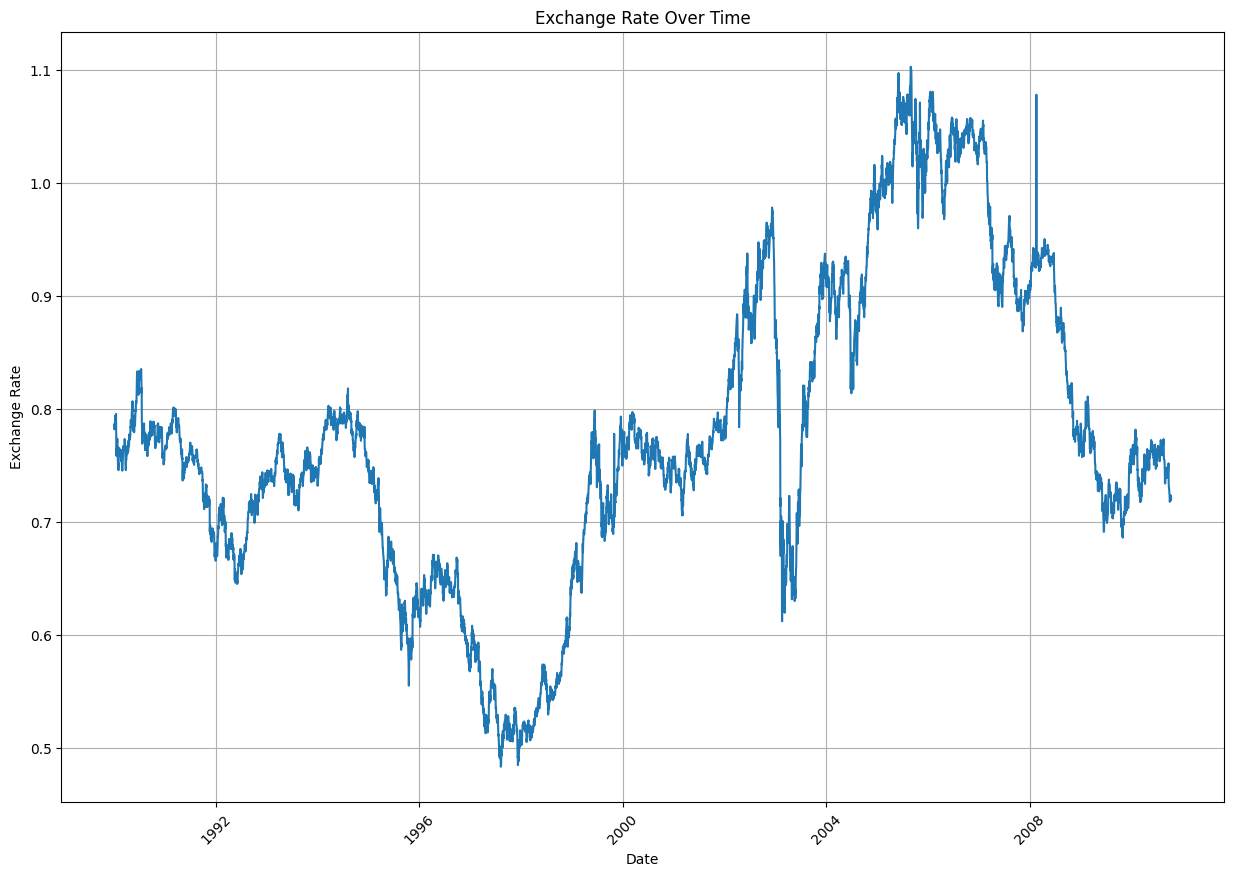

In [70]:
# Plot the time series for currency
fig, axes = plt.subplots(1, 1, figsize=(15, 10))

axes.plot(exchange_rate_df.index, exchange_rate_df['Ex_rate'])
# FIX: Use set_xlabel, set_ylabel, and set_title methods
axes.set_xlabel('Date')
axes.set_ylabel('Exchange Rate')
axes.set_title('Exchange Rate Over Time')
axes.xaxis.set_major_formatter(DateFormatter('%Y'))
# FIX: Apply plt.setp to the tick labels of the axes
plt.setp(axes.get_xticklabels(), rotation=45)
plt.grid(True)
plt.show()

* This plot shows date (x-axis) vs Ex_rate (USD to Australian Dollar) (y-axis)
* Over the span of years from the early 90s to the 2010s, the average exchange rate is close to 0.8.

* In the beginning, i.e., from the early 90s till late 90s, the exchange rate dropped
  from 0.8 to 0.5 (37.5% decrease). This means:
  * Early 90s: 1 USD = 0.8 AUD
  * Late 90s:  1 USD = 0.5 AUD
  * The Australian Dollar STRENGTHENED (1 USD buys fewer AUD)

* Then, from the late 90s until the early 2000s, the exchange rate increased back
  to average levels, before spiking to 1 USD = 1.1 AUD around 2001. This spike indicates:
  * Australian Dollar WEAKENED (1 USD buys more AUD)

* Post that peak, the exchange rate decreased and has been hovering around 0.8,
  indicating the AUD strengthened again.

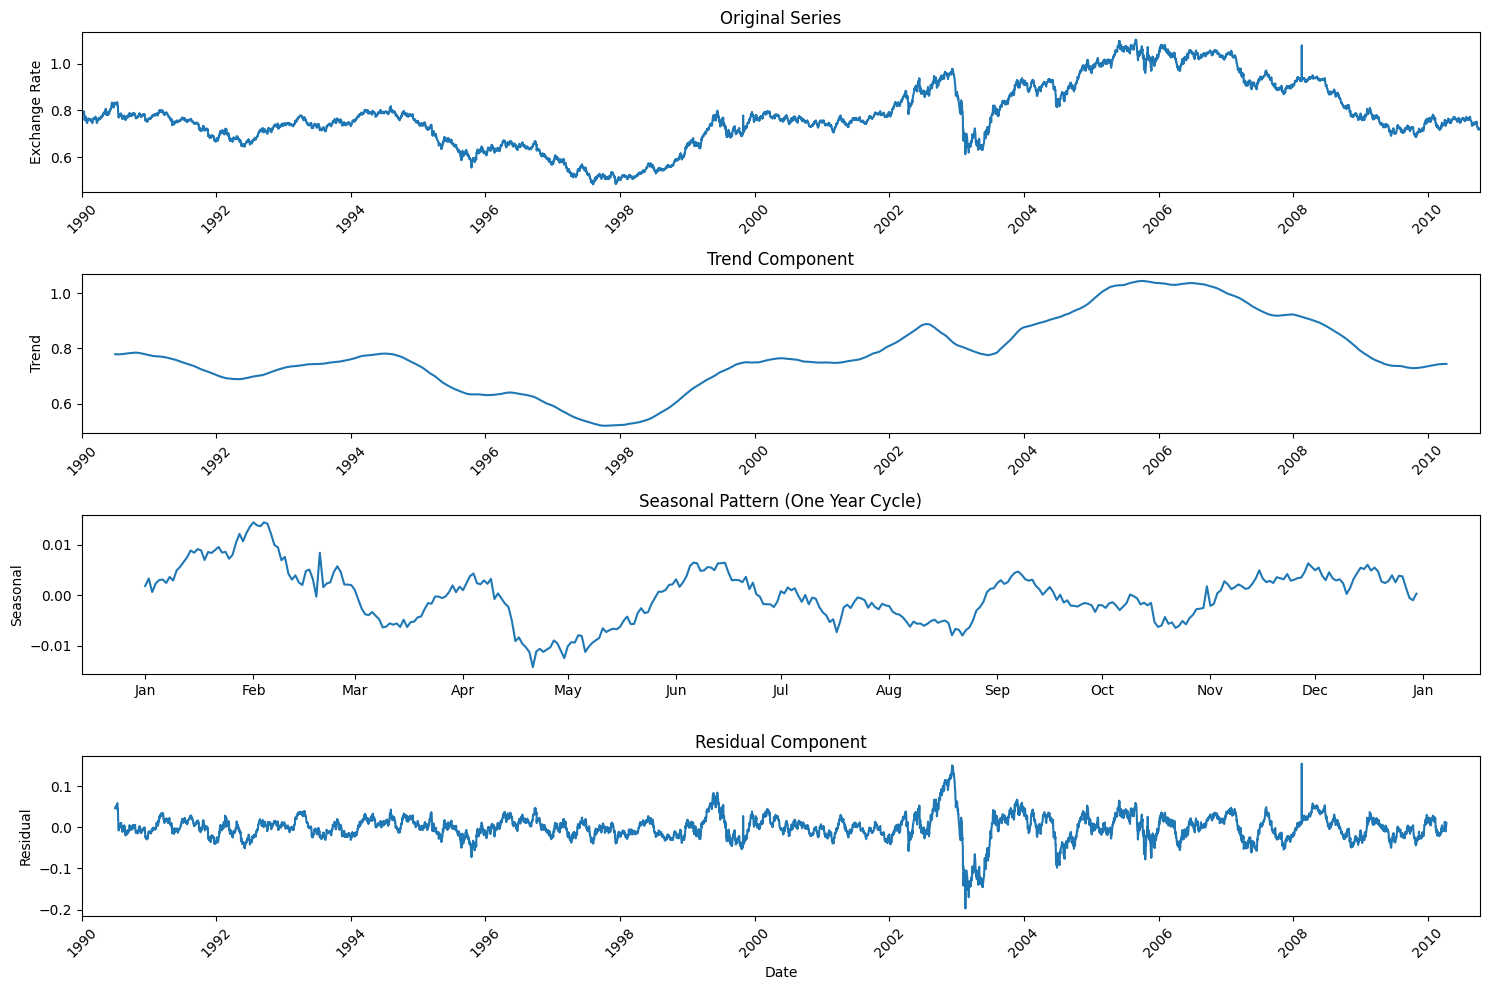

In [71]:
internal_exploration = seasonal_decompose(exchange_rate_df['Ex_rate'], period = 365)

fig, axes = plt.subplots(4, 1, figsize=(15, 10))

# Plot 1: Original Series (with actual dates)
axes[0].plot(exchange_rate_df.index, internal_exploration.observed)
axes[0].set_title('Original Series')
axes[0].set_ylabel('Exchange Rate')

# Plot 2: Trend Component (with actual dates)
axes[1].plot(exchange_rate_df.index, internal_exploration.trend)
axes[1].set_title('Trend Component')
axes[1].set_ylabel('Trend')

# Plot 3: Seasonal Component (map to calendar dates)
# Create a fake year for the seasonal pattern (e.g., 2000)
seasonal_dates = pd.date_range('2000-01-01', periods = 365, freq='D')
axes[2].plot(seasonal_dates, internal_exploration.seasonal[:365])
axes[2].set_title('Seasonal Pattern (One Year Cycle)')
axes[2].set_ylabel('Seasonal')
axes[2].xaxis.set_major_locator(MonthLocator())
axes[2].xaxis.set_major_formatter(DateFormatter('%b'))

# Plot 4: Residual Component (with actual dates)
axes[3].plot(exchange_rate_df.index, internal_exploration.resid)
axes[3].set_title('Residual Component')
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Date')

# Format all date axes
for ax in [axes[0], axes[1], axes[3]]:
    ax.set_xlim([exchange_rate_df.index.min(), exchange_rate_df.index.max()])
    ax.xaxis.set_major_locator(YearLocator(2))  # Show every 2 years
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

* Above is the seasonal_decompose of exchange rate, there are 4 plots:
* Original_Data = Trend + Seasonal + Residual
  * Decomposition - Original: Exchange rate as a function of sequence (every day), this is same as the exchange rate over time.
  * Decomposition - Trend: A smooth function (moving averages) is applied to know the long-term direction.
  * Decomposition - Seasonal: It shows the pattern that occurs over the span of 365 days (each year). In this dataset, same type of repeatation occurs every year.
  * Decomposition - Residual = (Original data - Trend - Seasonal): In this plot we can see the behaviour like big spikes, which means anomalies. Here, we see one anomaly (big fluctuation) nearing 2003 time period and one spike ~ 2008 time period.

In [72]:
# Quantitative anomaly detection
def detect_anomalies(series, method='iqr', threshold=3):
    """Systematic anomaly detection"""
    if method == 'iqr':
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        #print(Q1, Q3, IQR, lower_bound, upper_bound)
        anomalies = series[(series < lower_bound) | (series > upper_bound)]
    else:  # z-score method
        z_scores = np.abs((series - series.mean()) / series.std())
        anomalies = series[z_scores > threshold]

    return anomalies

In [73]:
# Detect and analyze anomalies
anomalies = detect_anomalies(exchange_rate_df['Ex_rate'])
print(f"Anomalies detected: {len(anomalies)}")
if len(anomalies) > 0:
    print("Anomaly dates and values:")
    for date, value in anomalies.items():
        print(f"  {date.date()}: {value:.4f}")

Anomalies detected: 0


* The IQR method does not indicate any anomalies, however, a spike is visible in the Residual plot.

In [74]:
# Instead of IQR, investigating the spike in residual plot
residuals = internal_exploration.resid

# Standard Deviation-based detection
residual_std = residuals.std()
anomaly_threshold = 3 * residual_std  # 3 standard deviations

visual_anomalies = residuals[np.abs(residuals) > anomaly_threshold]
print(f"Visual anomalies detected: {len(visual_anomalies)}")

if len(visual_anomalies) > 0:
    print("\n=== VISUAL ANOMALY ANALYSIS ===")
    for date, residual_value in visual_anomalies.items():
        original_value = exchange_rate_df.loc[date, 'Ex_rate']
        print(f"Date: {date.date()}")
        print(f"  Residual: {residual_value:.4f}")
        print(f"  Original Rate: {original_value:.4f}")
        print(f"  Standard Deviations: {abs(residual_value/residual_std):.1f}σ")

Visual anomalies detected: 180

=== VISUAL ANOMALY ANALYSIS ===
Date: 2002-10-09
  Residual: 0.0929
  Original Rate: 0.9488
  Standard Deviations: 3.0σ
Date: 2002-10-14
  Residual: 0.0938
  Original Rate: 0.9432
  Standard Deviations: 3.0σ
Date: 2002-10-17
  Residual: 0.0962
  Original Rate: 0.9455
  Standard Deviations: 3.1σ
Date: 2002-10-18
  Residual: 0.1017
  Original Rate: 0.9492
  Standard Deviations: 3.3σ
Date: 2002-10-19
  Residual: 0.0969
  Original Rate: 0.9443
  Standard Deviations: 3.1σ
Date: 2002-10-20
  Residual: 0.0986
  Original Rate: 0.9444
  Standard Deviations: 3.2σ
Date: 2002-10-21
  Residual: 0.0960
  Original Rate: 0.9417
  Standard Deviations: 3.1σ
Date: 2002-10-22
  Residual: 0.1001
  Original Rate: 0.9464
  Standard Deviations: 3.2σ
Date: 2002-10-23
  Residual: 0.0969
  Original Rate: 0.9421
  Standard Deviations: 3.1σ
Date: 2002-10-26
  Residual: 0.1078
  Original Rate: 0.9546
  Standard Deviations: 3.5σ
Date: 2002-10-27
  Residual: 0.1066
  Original Rate: 0.9

* This result shows all the Residual, Original exchange rate with SD > 3SD.
* It can be noticed that between 2002 and 2003, continous 241 days, the SD is > 3SD. This is not anomoly but a statistically significant change (structural) and it should not be removed.

In [75]:
anomaly_date = visual_anomalies.index[0]
print('1st day of structural change', visual_anomalies.index[0])
print('last contionus day of structural change', visual_anomalies.index[-3])

1st day of structural change 2002-10-09 00:00:00
last contionus day of structural change 2003-06-07 00:00:00


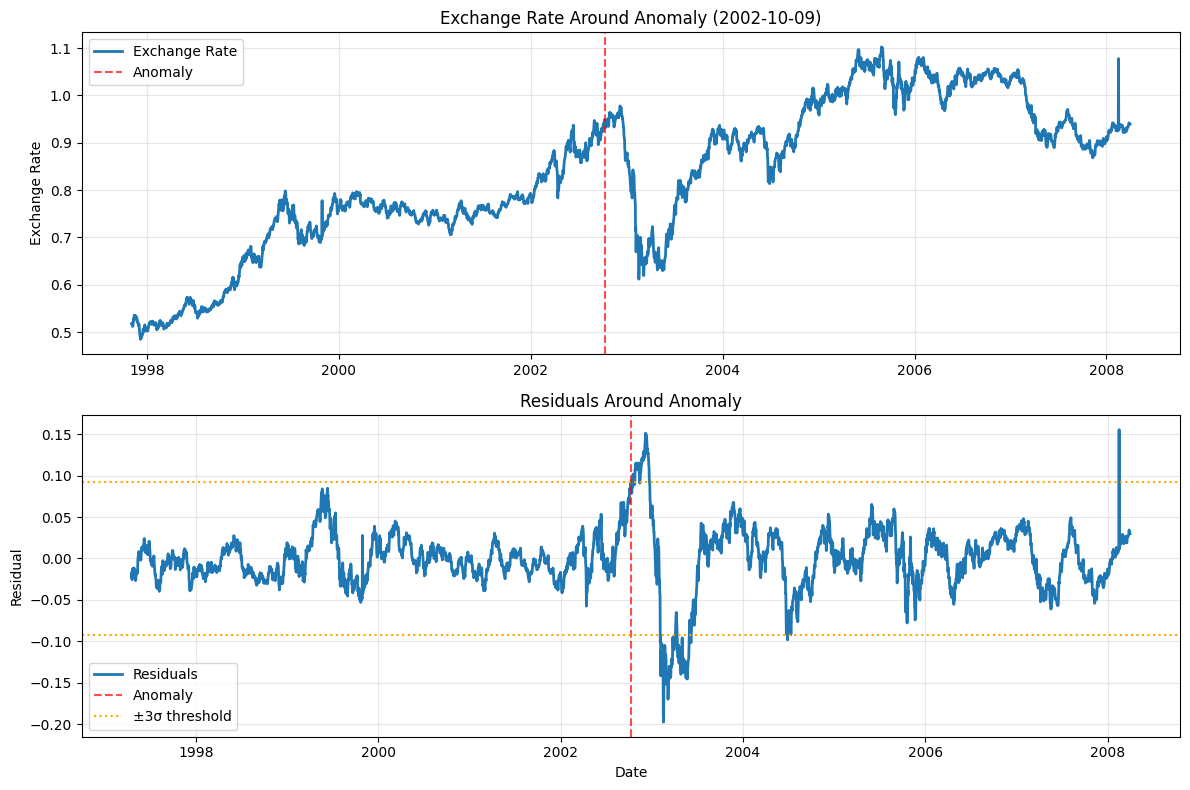

In [76]:
# Create a focused plot around the anomaly
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

# Plot 1: Original data around anomaly
anomaly_context = exchange_rate_df.loc[anomaly_date - pd.Timedelta(days = 1800):
                                      anomaly_date + pd.Timedelta(days = 2000)]
ax1.plot(anomaly_context.index, anomaly_context['Ex_rate'], label = 'Exchange Rate', linewidth = 2)
ax1.axvline(anomaly_date, color = 'red', linestyle='--', alpha = 0.7, label = 'Anomaly')
ax1.set_title(f'Exchange Rate Around Anomaly ({anomaly_date.date()})')
ax1.set_ylabel('Exchange Rate')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Residuals around anomaly
residual_context = residuals.loc[anomaly_date - pd.Timedelta(days = 2000):
                                anomaly_date + pd.Timedelta(days = 2000)]
ax2.plot(residual_context.index, residual_context, label = 'Residuals', linewidth = 2)
ax2.axvline(anomaly_date, color = 'red', linestyle = '--', alpha = 0.7, label = 'Anomaly')
ax2.axhline(y=anomaly_threshold, color = 'orange', linestyle = ':', label = '±3σ threshold')
ax2.axhline(y=-anomaly_threshold, color = 'orange', linestyle = ':')
ax2.set_title('Residuals Around Anomaly')
ax2.set_ylabel('Residual')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True, alpha = 0.3)

plt.tight_layout()
plt.show()

* Dates: 2002-10-09 to 2002-12-31
* Residuals: +0.09 to +0.15 (all POSITIVE)
* Interpretation:
  * AUD consistently WEAKER than expected
  * 1 USD bought 0.09-0.15 more AUD than historical patterns suggested
  * Market was not performing well wrt AUD beyond normal range

* Dates: 2003-02-04 to 2003-06-07  
* Residuals: -0.09 to -0.19 (all NEGATIVE)
* Interpretation:
  * AUD consistently STRONGER than expected
  * 1 USD bought 0.09-0.19 lesser AUD than historical patterns suggested  
  * Market was performing well wrt AUD beyond normal range    

In [77]:
# Understand which component drove the anomaly
def analyze_anomaly_components(anomaly_date):
    """Break down what caused the residual spike"""
    trend_val = internal_exploration.trend.loc[anomaly_date]
    seasonal_val = internal_exploration.seasonal.loc[anomaly_date]
    observed_val = internal_exploration.observed.loc[anomaly_date]
    residual_val = internal_exploration.resid.loc[anomaly_date]

    print(f"Observed:    {observed_val:.4f}")
    print(f"Trend:       {trend_val:.4f}")
    print(f"Seasonal:    {seasonal_val:.4f}")
    print(f"Residual:    {residual_val:.4f}")
    print(f"Expected:    {trend_val + seasonal_val:.4f} (Trend + Seasonal)")
    print(f"Difference:  {residual_val:.4f} (Observed - Expected)")

    # Check if it's a trend break or one-off shock
    trend_before = internal_exploration.trend.loc[anomaly_date - pd.Timedelta(days = 241):anomaly_date].mean()
    trend_after = internal_exploration.trend.loc[anomaly_date:anomaly_date + pd.Timedelta(days = 241)].mean()
    trend_change = ((trend_after - trend_before) / trend_before) * 100

    print(f"Trend change: {trend_change:+.1f}% (before vs after 241 days)")

analyze_anomaly_components(anomaly_date)

Observed:    0.9488
Trend:       0.8565
Seasonal:    -0.0006
Residual:    0.0929
Expected:    0.8559 (Trend + Seasonal)
Difference:  0.0929 (Observed - Expected)
Trend change: -6.5% (before vs after 241 days)


**Data Preprocessing**

In [78]:
exchange_rate_clean = exchange_rate_df.copy()
print("Original data shape:", exchange_rate_clean.shape)

Original data shape: (7588, 1)


In [79]:
# Check for missing entries
exchange_rate_clean.isnull().sum().sum()

np.int64(0)

* No missing data.

In [80]:
def analyze_anomalies(df):

    # Method 1: Statistical (IQR)
    Q1 = df['Ex_rate'].quantile(0.25)
    Q3 = df['Ex_rate'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    iqr_anomalies = df[(df['Ex_rate'] < lower_bound) | (df['Ex_rate'] > upper_bound)]
    print(f"IQR anomalies: {len(iqr_anomalies)} points")

    # Method 2: Z-score (for comparison)
    from scipy import stats
    z_scores = np.abs(stats.zscore(df['Ex_rate']))
    z_anomalies = df[z_scores > 3]
    print(f"Z-score anomalies (>3σ): {len(z_anomalies)} points")

    # Method 3: Your residual-based anomalies (most meaningful)
    decomposition = seasonal_decompose(df['Ex_rate'], period=365)
    residuals = decomposition.resid
    residual_anomalies = residuals[np.abs(residuals) > 3 * residuals.std()]
    print(f"Residual anomalies (>3σ): {len(residual_anomalies)} points")

    return {
        'iqr_anomalies': iqr_anomalies,
        'z_anomalies': z_anomalies,
        'residual_anomalies': residual_anomalies
    }

anomaly_report = analyze_anomalies(exchange_rate_clean)
print(anomaly_report)

IQR anomalies: 0 points
Z-score anomalies (>3σ): 0 points
Residual anomalies (>3σ): 180 points
{'iqr_anomalies': Empty DataFrame
Columns: [Ex_rate]
Index: [], 'z_anomalies': Empty DataFrame
Columns: [Ex_rate]
Index: [], 'residual_anomalies': date
2002-10-09    0.092922
2002-10-14    0.093815
2002-10-17    0.096187
2002-10-18    0.101677
2002-10-19    0.096901
                ...   
2003-05-31   -0.094458
2003-06-06   -0.096719
2003-06-07   -0.101652
2004-06-28   -0.098231
2008-02-16    0.155369
Name: resid, Length: 180, dtype: float64}


In [81]:
def make_preprocessing_decision(df, anomaly_report, gap_threshold, capping_std):
    """
    Preprocessing function:
    - Identifies clusters and isolated anomalies
    - Adds regime flags
    - Caps isolated extremes
    Returns: Processed DataFrame with regime flags
    """

    df_processed = df.copy()
    anomaly_dates = anomaly_report['residual_anomalies'].index

    print(f" Preprocessing Analysis:")
    print(f"   Total anomalies: {len(anomaly_dates)}")
    print(f"   Gap threshold: {gap_threshold} days")
    print(f"   Capping threshold: {capping_std}σ")

    # Step 1: Identify clusters
    dates_sorted = sorted(anomaly_dates)
    clusters = []
    current_cluster = [dates_sorted[0]] if dates_sorted else []

    for i in range(1, len(dates_sorted)):
        gap = (dates_sorted[i] - dates_sorted[i-1]).days
        if gap <= gap_threshold:
            current_cluster.append(dates_sorted[i])
        else:
            clusters.append(current_cluster)
            current_cluster = [dates_sorted[i]]

    if current_cluster:
        clusters.append(current_cluster)

    # Step 2: Separate clusters from isolated anomalies
    significant_clusters = []
    isolated_anomalies = []

    for cluster in clusters:
        if len(cluster) >= 5:  # At least 5 consecutive anomalies = significant cluster
            significant_clusters.append(cluster)
        else:
            isolated_anomalies.extend(cluster)

    print(f"   Significant clusters: {len(significant_clusters)}")
    print(f"   Isolated anomalies: {len(isolated_anomalies)}")

    # Step 3: Add regime flags
    df_processed['regime_break'] = 0

    for i, cluster in enumerate(significant_clusters):
        start_date = min(cluster)
        end_date = max(cluster)
        df_processed.loc[start_date:end_date, 'regime_break'] = 1
        print(f" Regime {i+1}: {start_date.date()} to {end_date.date()} "
              f"({len(cluster)} days, {(end_date - start_date).days} day span)")

    # Step 4: Capping using capping_std parameter
    if isolated_anomalies:
        print(f"\n Capping {len(isolated_anomalies)} isolated anomalies using {capping_std}σ rule:")
        print(isolated_anomalies)

        # Calculate rolling statistics (mean + std)
        rolling_mean = df_processed['Ex_rate'].rolling(window = 30, center = True).mean()
        rolling_std = df_processed['Ex_rate'].rolling(window = 30, center = True).std()

        caps_applied = 0
        for spike_date in isolated_anomalies:
            if spike_date in df_processed.index:
                original_value = df_processed.loc[spike_date, 'Ex_rate']

                # Calculate bounds using capping_std parameter
                upper_bound = rolling_mean.loc[spike_date] + capping_std * rolling_std.loc[spike_date]
                print(f"{spike_date.date()}: {original_value:.4f} → {upper_bound:.4f} (above +{capping_std}σ)")
                lower_bound = rolling_mean.loc[spike_date] - capping_std * rolling_std.loc[spike_date]
                print(f"{spike_date.date()}: {original_value:.4f} → {lower_bound:.4f} (below -{capping_std}σ)")

                # Cap values outside the bounds
                if original_value > upper_bound:
                    df_processed.loc[spike_date, 'Ex_rate'] = upper_bound
                    print(f"{spike_date.date()}: {original_value:.4f} → {upper_bound:.4f} (above +{capping_std}σ)")
                    caps_applied += 1
                elif original_value < lower_bound:
                    df_processed.loc[spike_date, 'Ex_rate'] = lower_bound
                    print(f"{spike_date.date()}: {original_value:.4f} → {lower_bound:.4f} (below -{capping_std}σ)")
                    caps_applied += 1

        print(f" Applied {caps_applied} caps")

    # Final summary
    regime_days = df_processed['regime_break'].sum()
    print(f"\n Preprocessing complete:")
    print(f"   Final shape: {df_processed.shape}")
    print(f"   Regime days: {regime_days} ({regime_days/len(df_processed)*100:.1f}%)")
    print(f"   Columns: {list(df_processed.columns)}")

    return df_processed

In [82]:
exchange_rate_processed = make_preprocessing_decision(exchange_rate_clean, anomaly_report, gap_threshold = 15, capping_std = 3)
print(exchange_rate_processed)

 Preprocessing Analysis:
   Total anomalies: 180
   Gap threshold: 15 days
   Capping threshold: 3σ
   Significant clusters: 2
   Isolated anomalies: 2
 Regime 1: 2002-10-09 to 2002-12-22 (66 days, 74 day span)
 Regime 2: 2003-02-04 to 2003-06-07 (112 days, 123 day span)

 Capping 2 isolated anomalies using 3σ rule:
[Timestamp('2004-06-28 00:00:00'), Timestamp('2008-02-16 00:00:00')]
2004-06-28: 0.8137 → 0.9333 (above +3σ)
2004-06-28: 0.8137 → 0.7660 (below -3σ)
2008-02-16: 1.0778 → 1.0178 (above +3σ)
2008-02-16: 1.0778 → 0.8558 (below -3σ)
2008-02-16: 1.0778 → 1.0178 (above +3σ)
 Applied 1 caps

 Preprocessing complete:
   Final shape: (7588, 2)
   Regime days: 199 (2.6%)
   Columns: ['Ex_rate', 'regime_break']
             Ex_rate  regime_break
date                              
1990-01-01  0.785500             0
1990-01-02  0.781800             0
1990-01-03  0.786700             0
1990-01-04  0.786000             0
1990-01-05  0.784900             0
...              ...           ..

**Part 2: Model Building - ARIMA (AutoRegressive Integrated Moving Average)**

*	Parameter Selection for ARIMA: Utilize ACF (AutoCorrelation Function) and PACF (Partial AutoCorrelation Function) plots to estimat initial parameters
(p, d, q) for the ARIMA model for one or more currency time series.

*	Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.

*	Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.

*	Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.

In [83]:
# To check for stationarity
# Augmented Dickey-Fuller Test: ADF
from statsmodels.tsa.stattools import adfuller
# To Generate ACF and PACF plots
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Model ARIMA
from statsmodels.tsa.arima.model import ARIMA

In [84]:
def check_stationarity(timeseries, window = 365):
  # Rolling statistics
  rolling_mean = timeseries.rolling(window = window, center = True).mean()
  rolling_std = timeseries.rolling(window = window, center = True).std()
  # ADF test
  result_adf = adfuller(timeseries)
  print(f'ADF Statistic: {result_adf[0]}')
  print(f'p-value: {result_adf[1]}')

  print('Critical Values:')
  for key, value in result_adf[4].items():
    print(f'   {key}: {value:.3f}')

  is_stationary = result_adf[1] < 0.05
  print(f'Stationary: {is_stationary}')

  # Plot rolling statistics
  fig, axes = plt.subplots(2, 1, figsize=(12, 10))

  # Original series with rolling mean
  axes[0].plot(timeseries, label = 'Original', alpha = 0.7)
  axes[0].plot(rolling_mean, label = f'Rolling Mean ({window} days)', color = 'red', linewidth = 2)
  axes[0].set_title('Exchange Rate with Rolling Mean')
  axes[0].legend()
  axes[0].grid(True, alpha = 0.3)

  # Rolling standard deviation
  axes[1].plot(rolling_std, label = f'Rolling Std ({window} days)', color = 'green', linewidth = 2)
  axes[1].set_title('Rolling Standard Deviation')
  axes[1].legend()
  axes[1].grid(True, alpha = 0.3)

  plt.tight_layout()
  plt.show()

  return is_stationary


ADF Statistic: -1.667148597942404
p-value: 0.4481129993155032
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567
Stationary: False


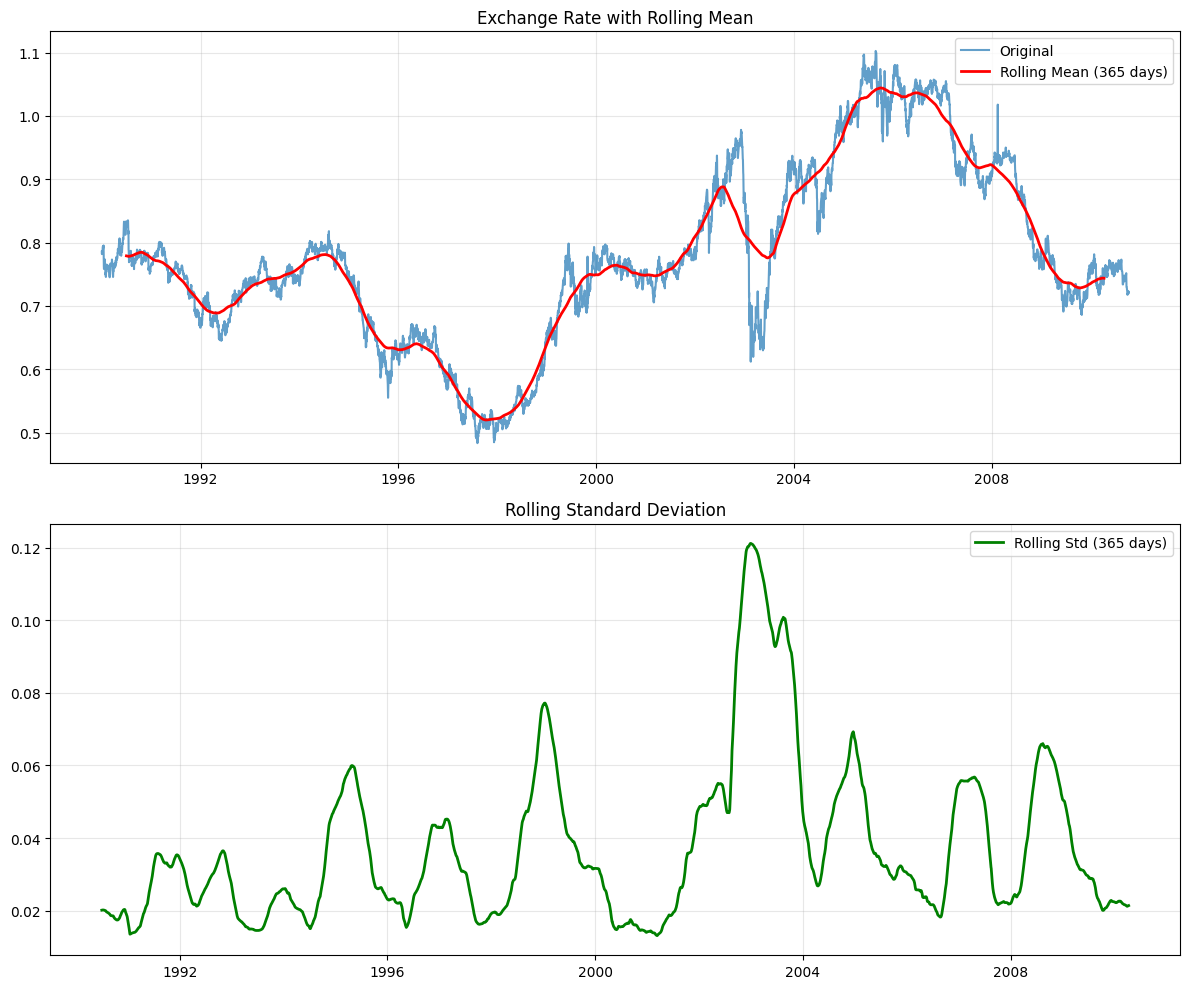

In [85]:
is_stationary = check_stationarity(exchange_rate_processed['Ex_rate'])

* ADF Statistic: -1.667

  * More negative = stronger evidence for stationarity
  * ADF Statistic is not negative enough to indicate stationarity

* p-value: 0.448

  * p-value > 0.05 = Fail to reject null hypothesis
  * Null hypothesis: The series is non-stationary
  * Conclusion: Loaded data is non-stationary

* Critical Values Comparison:

  * 1%:- ADF Statistic > -3.431 -> Not stationary at 99% confidence
  * 5%:- ADF Statistic > -2.862 -> Not stationary at 95% confidence  
  * 10%:- ADF Statistic > -2.567 -> Not stationary at 90% confidence

*Note: If ADF statistic > critical value → Non-stationary*

* Since ADF Statistics in comparision with Critical Values (Fixed) and also probability (Calculated) Values, both suggest Non-Stationarity. This will be a problem during forecasting as no references (Mean/Variance) can be established.

* In order to build ARIMA (AutoRegressive Integrated Moving Average) model, the parameters should be constant and this will not happen with Non-Stationarity data. Therefore, this data has to be transformed, here I apply Differencing method (i - (i+1)).

0 th step non-stationary
Data is non-stationary. Applying differencing...
ADF Statistic: -30.715664458091858
p-value: 0.0
Critical Values:
   1%: -3.431
   5%: -2.862
   10%: -2.567
Stationary: True


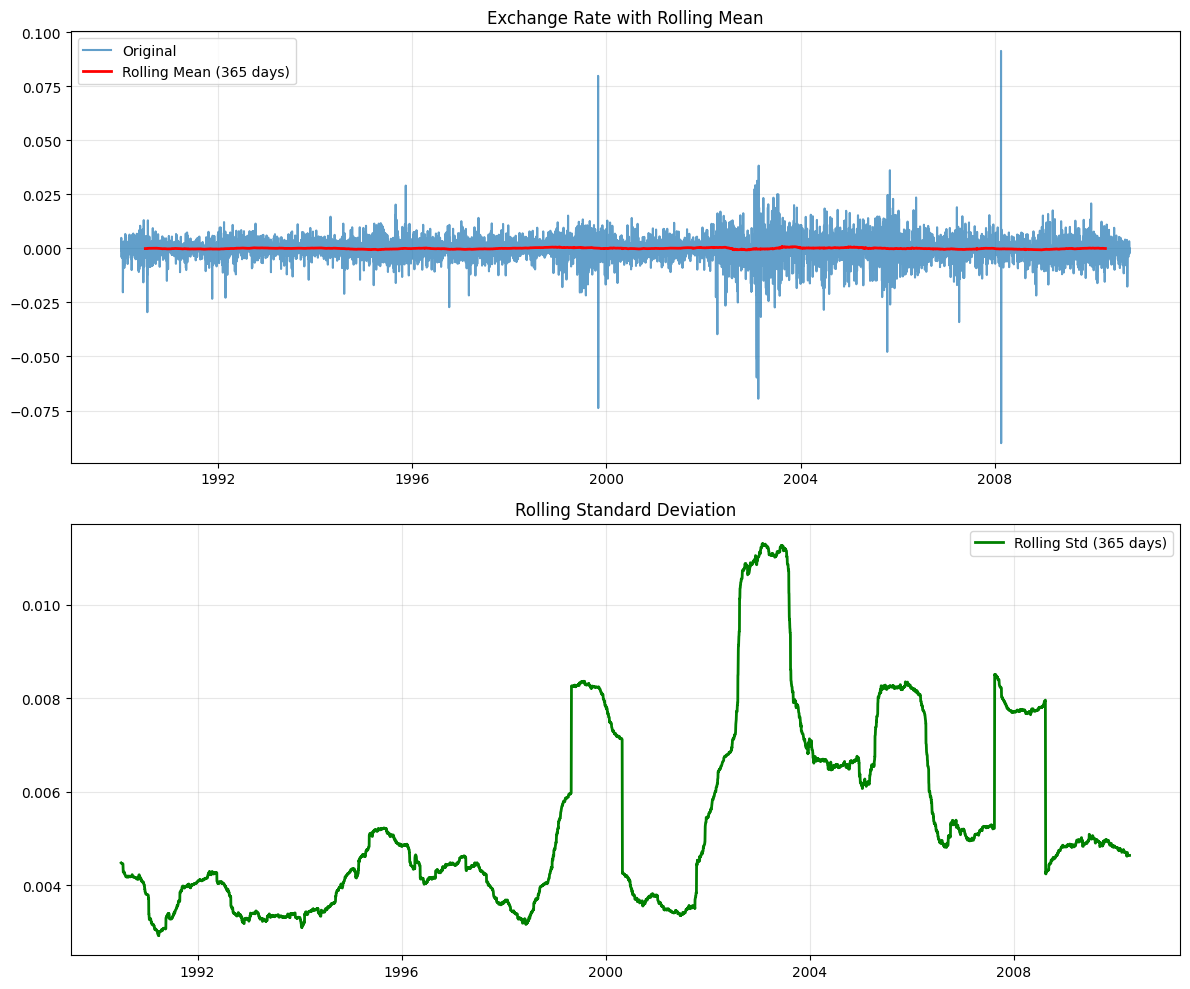

In [86]:
# If non-stationary, apply differencing
def make_stationary(data, diff_order = 1):

    differentiated = data.diff(periods = diff_order).dropna()

    # Test stationarity again
    is_stationary_after_diff = check_stationarity(differentiated)

    return differentiated, is_stationary_after_diff

# Apply differencing if needed
i, j = 0, 0
if not is_stationary:
  print(i, 'th step non-stationary')
  print("Data is non-stationary. Applying differencing...")
  stationary_data, is_now_stationary = make_stationary(exchange_rate_processed['Ex_rate'])
  i = i + 1
else:
  print(j, 'th step already stationary')
  stationary_data = exchange_rate_processed['Ex_rate']
  print("Data is already stationary.")
  j = j + 1

* ADF Statistic (New01): -30.716

  * This is EXTREMELY negative (about 18 times than original: -1.667
  * Strong evidence of stationarity

* p-value: 0.0

  * p-value < 0.01 means 99.99% confidence it's stationary
  * Actually 0.0 means the probability it's non-stationary is virtually zero
  * Strongest possible evidence for stationarity

* Critical Values Comparison:

  * 1%: ADF Statistic (New01) < -3.431 -> Stationary at 99% confidence
  * 5%: ADF Statistic (New01) < -2.862 -> Stationary at 95% confidence
  * 10%: ADF Statistic (New01) < -2.567 -> Stationary at 90% confidence

* Using ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model.

* AR (AutoRegressive) - p
  * Concept: Uses past values to predict future values
  * Formula: yₜ = c + φ₁yₜ₋₁ + φ₂yₜ₋₂ + ... + φₚyₜ₋ₚ + εₜ
* I (Integrated) - d
  * Concept: Differencing to make the series stationary
  * Purpose: Removes trend and seasonality  
* MA (Moving Average) - q
  * Concept: Uses past forecast errors to predict future value
  * Formula: yₜ = μ + εₜ + θ₁εₜ₋₁ + θ₂εₜ₋₂ + ... + θ𝚚εₜ₋𝚚  

`*d = 1 and p, q to be estimated  *

In [87]:
def plot_acf_pacf_analysis(data, lags=40):

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Original series
    axes[0, 0].plot(data)
    axes[0, 0].set_title('Stationary Time Series (Differenced Data)')
    axes[0, 0].set_ylabel('Exchange Rate Changes')
    axes[0, 0].grid(True, alpha=0.3)

    # ACF plot
    plot_acf(data, lags=lags, ax=axes[0, 1], alpha=0.05)
    axes[0, 1].set_title('Autocorrelation Function (ACF)')
    axes[0, 1].set_ylabel('Correlation')
    axes[0, 1].set_xlabel('Lag')

    # PACF plot
    plot_pacf(data, lags=lags, ax=axes[1, 0], alpha=0.05, method='ywm')
    axes[1, 0].set_title('Partial Autocorrelation Function (PACF)')
    axes[1, 0].set_ylabel('Partial Correlation')
    axes[1, 0].set_xlabel('Lag')

    plt.tight_layout()
    plt.show()

    return fig

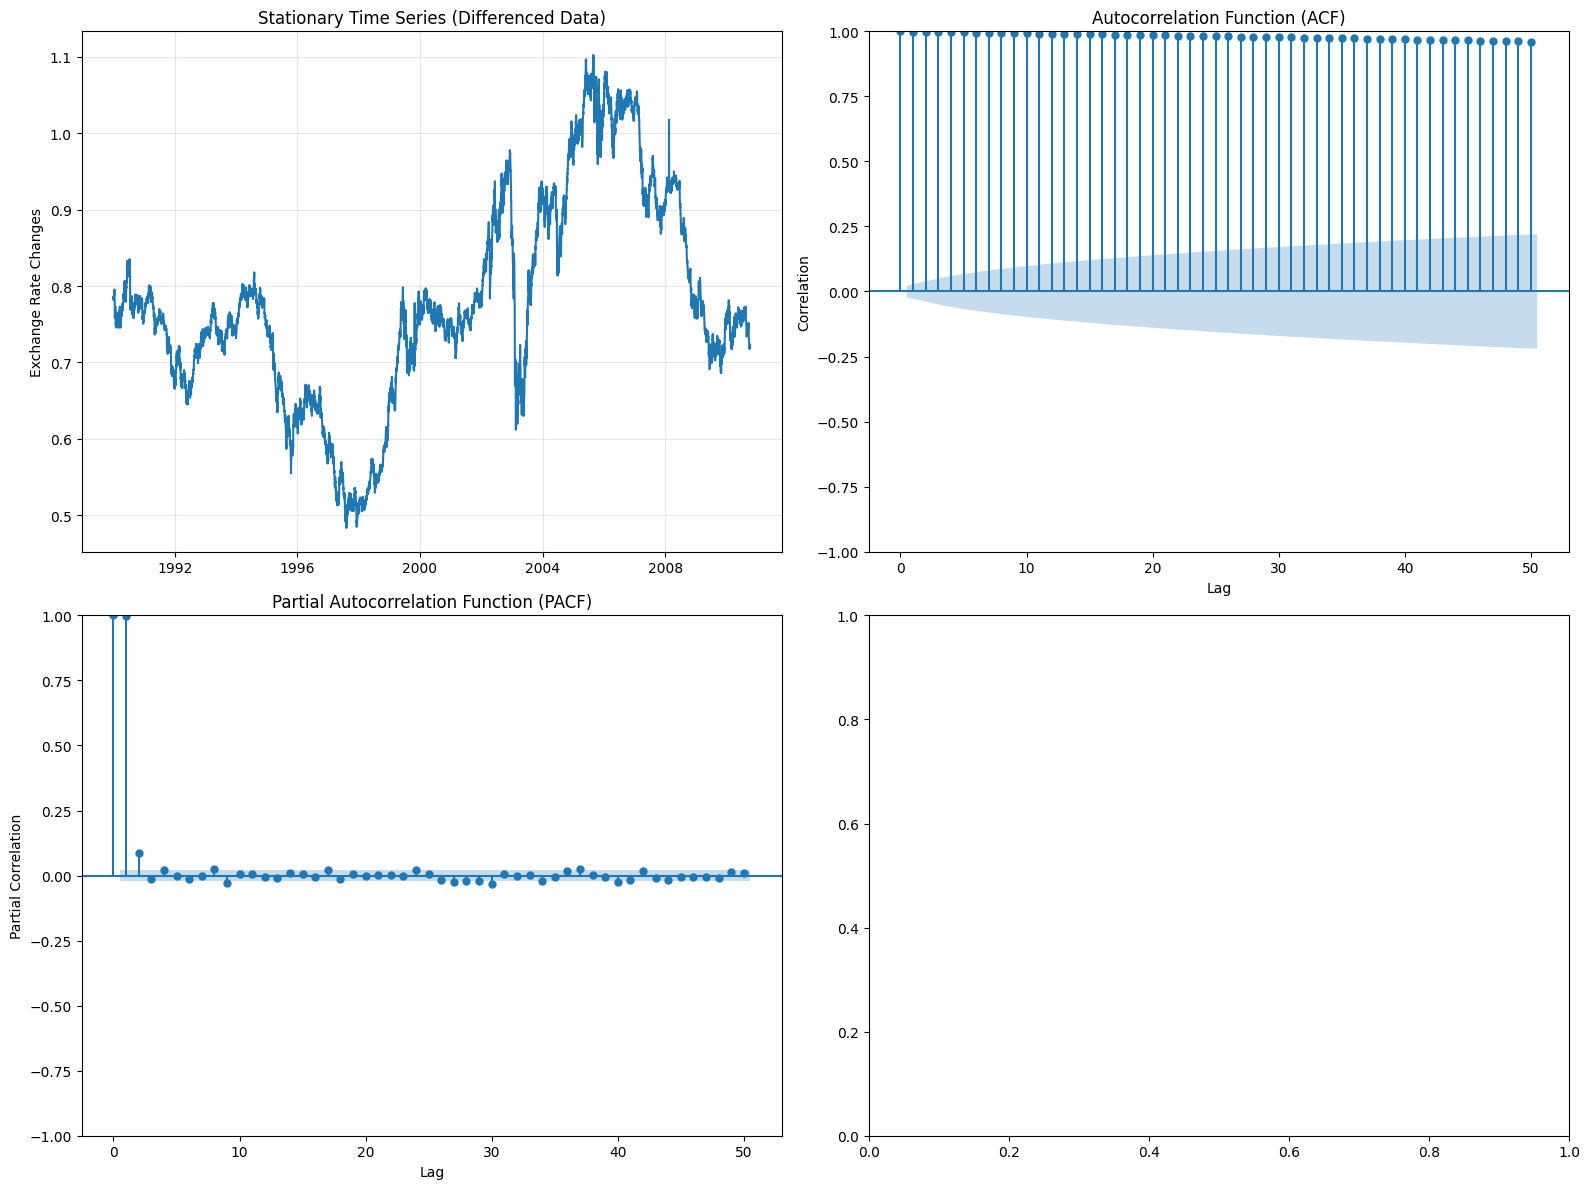

In [88]:
# Now generate ACF/PACF plots on your STATIONARY differenced data
acf_pacf_fig = plot_acf_pacf_analysis(exchange_rate_processed['Ex_rate'], lags = 50)

In [89]:
# Parameter Selection for ARIMA
def suggest_arima_parameters(data, max_lag = 20, pacf_threshold = 0.2, acf_threshold = 0.2):
    """
    Automatically suggest ARIMA parameters based on ACF/PACF analysis
    """

    # Calculate ACF and PACF
    acf_vals = acf(data, nlags = max_lag, alpha = 0.05)
    pacf_vals = pacf(data, nlags = max_lag, alpha = 0.05, method = 'ywm')

    acf_values = acf_vals[0]  # Actual correlation values
    pacf_values = pacf_vals[0]  # Actual partial correlation values

    # Find significant lags
    significant_pacf = np.where(np.abs(pacf_values[1:]) > pacf_threshold)[0] + 1  # +1 because we skip lag 0
    significant_acf = np.where(np.abs(acf_values[1:]) > acf_threshold)[0] + 1

    print("=== ARIMA initial parameter suggestions ===")

    # Suggest p (AR order) - look for cutoff in PACF
    if len(significant_pacf) > 0:
        p_suggestion = significant_pacf[0]  # First significant lag in PACF
        print(f"Suggested p (AR order): {p_suggestion}")
        print(f"  - PACF cuts off after lag {p_suggestion}")
    else:
        p_suggestion = 0
        print("Suggested p (AR order): 0 (no significant AR component)")

    # Suggest q (MA order) - look for cutoff in ACF
    if len(significant_acf) > 0:
        q_suggestion = significant_acf[0]  # First significant lag in ACF
        print(f"Suggested q (MA order): {q_suggestion}")
        print(f"  - ACF cuts off after lag {q_suggestion}")
    else:
        q_suggestion = 0
        print("Suggested q (MA order): 0 (no significant MA component)")

    # Determine d (based on stationarity)
    d_suggestion = 1 if not is_stationary else 0
    print(f"Suggested d (differencing): {d_suggestion}")

    print(f"\nInitial ARIMA order: ({p_suggestion}, {d_suggestion}, {q_suggestion})")

    return (p_suggestion, d_suggestion, q_suggestion)

# Get automated parameter suggestions
suggested_order = suggest_arima_parameters(stationary_data)

=== ARIMA initial parameter suggestions ===
Suggested p (AR order): 0 (no significant AR component)
Suggested q (MA order): 0 (no significant MA component)
Suggested d (differencing): 1

Initial ARIMA order: (0, 1, 0)


In [90]:
# Fit ARIMA(0,1,0) - Random Walk model
model_010 = ARIMA(exchange_rate_processed['Ex_rate'], order = (0, 1, 0))
fitted_model_010 = model_010.fit()

In [91]:
# Display key model information
print("\n=== MODEL: 0, 1, 0 RESULTS ===")
print(f"AIC: {fitted_model_010.aic:.2f}")
print(f"BIC: {fitted_model_010.bic:.2f}")
print(f"Log-Likelihood: {fitted_model_010.llf:.2f}")

# Check if coefficients are significant
print("\n=== COEFFICIENTS ===")
print(fitted_model_010.params)


=== MODEL: 0, 1, 0 RESULTS ===
AIC: -56810.02
BIC: -56803.09
Log-Likelihood: 28406.01

=== COEFFICIENTS ===
sigma2    0.000033
dtype: float64


* These results indicate minimal data dispersion, with very low AIC and BIC values, which generally signify a strong model fit.

* AIC (Akaike Information Criterion) assesses model quality:

  * AIC = 2k - 2ln(L), where k is the number of parameters and L is the likelihood.

* BIC (Bayesian Information Criterion) is a more stringent model assessment:

  * BIC = k ln(n) - 2 ln(L), where n as sample size, k as number of parameters, and L as likelihood.

* Comparing penalties: AIC: 2k = 2 × 1 = 2; BIC: k ln(n) = 1 × ln(7588) = 8.93.

* BIC enforces a stronger penalty for complexity.

* Log-Likelihood quantifies how well the model explains the data.

* (1 - p x L)(1 - L)yₜ = (1 + q x L)εₜ, where p and q are 0, and L is Lag Operator that shifts time series back one step. The equation simplifies to

  * yₜ - Lyₜ = εₜ or ∇yₜ = εₜ or yₜ - yₜ₋₁ = εₜ

* Such a model is referred as random walk model as Daily Change (yₜ - yₜ₋₁) = Random Noise (εₜ)

* This model is statistically strong: AIC and BIC are very negative, sigma2 is small, and log-likelihood is large. These metrics collectively show that daily exchange rate changes cannot be reliably predicted using only past prices. As a result, the data support the main conclusion that the random walk model offers the best fit for this scenario.

In [92]:
# Model Diagnostics
from scipy.stats import normaltest

In [93]:
residuals_010 = fitted_model_010.resid[1:]
print(f"Residuals - Mean: {residuals_010.mean():.6f}, Std: {residuals_010.std():.6f}")
print(f"Residuals - sigma2: {fitted_model_010.params['sigma2']:.6f}")

Residuals - Mean: -0.000009, Std: 0.005725
Residuals - sigma2: 0.000033


In [94]:
residual_acf_010 = acf(residuals_010, nlags=20, alpha=0.05)
significant_residual_lags = [i for i in range(1, 21) if abs(residual_acf_010[0][i]) > 2/len(residuals_010)**0.5]
print(f"Significant ACF in residuals: {significant_residual_lags}")

_, p_value = normaltest(residuals.dropna())
print(f"Normality test p-value: {p_value:.4f}")

Significant ACF in residuals: [1, 3, 7, 8]
Normality test p-value: 0.0000


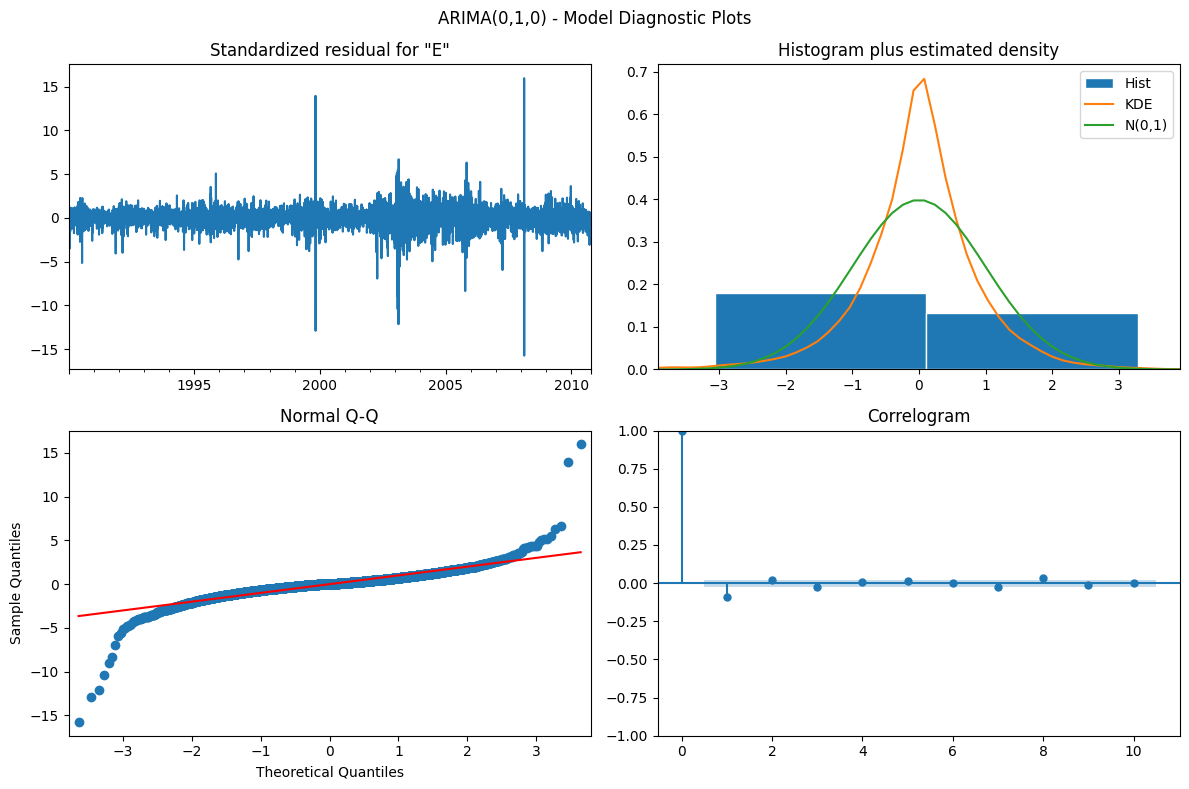

In [95]:
fitted_model_010.plot_diagnostics(figsize=(12, 8))
plt.suptitle('ARIMA(0,1,0) - Model Diagnostic Plots')
plt.tight_layout()
plt.show()

* Lags 1, 3, 7, 8 show significant correlation. Meaning: The residuals (errors) have a structure that is not captured by this model (model_010).

* Residuals are NOT normally distributed (p-value: 0.0000). Meaning: The random noise component doesn't follow the normal distribution assumption. This can be visually confirmed on the Normal Q-Q plot, points at the tail deviate from the red line.

* Next examine the ACF patterns more closely

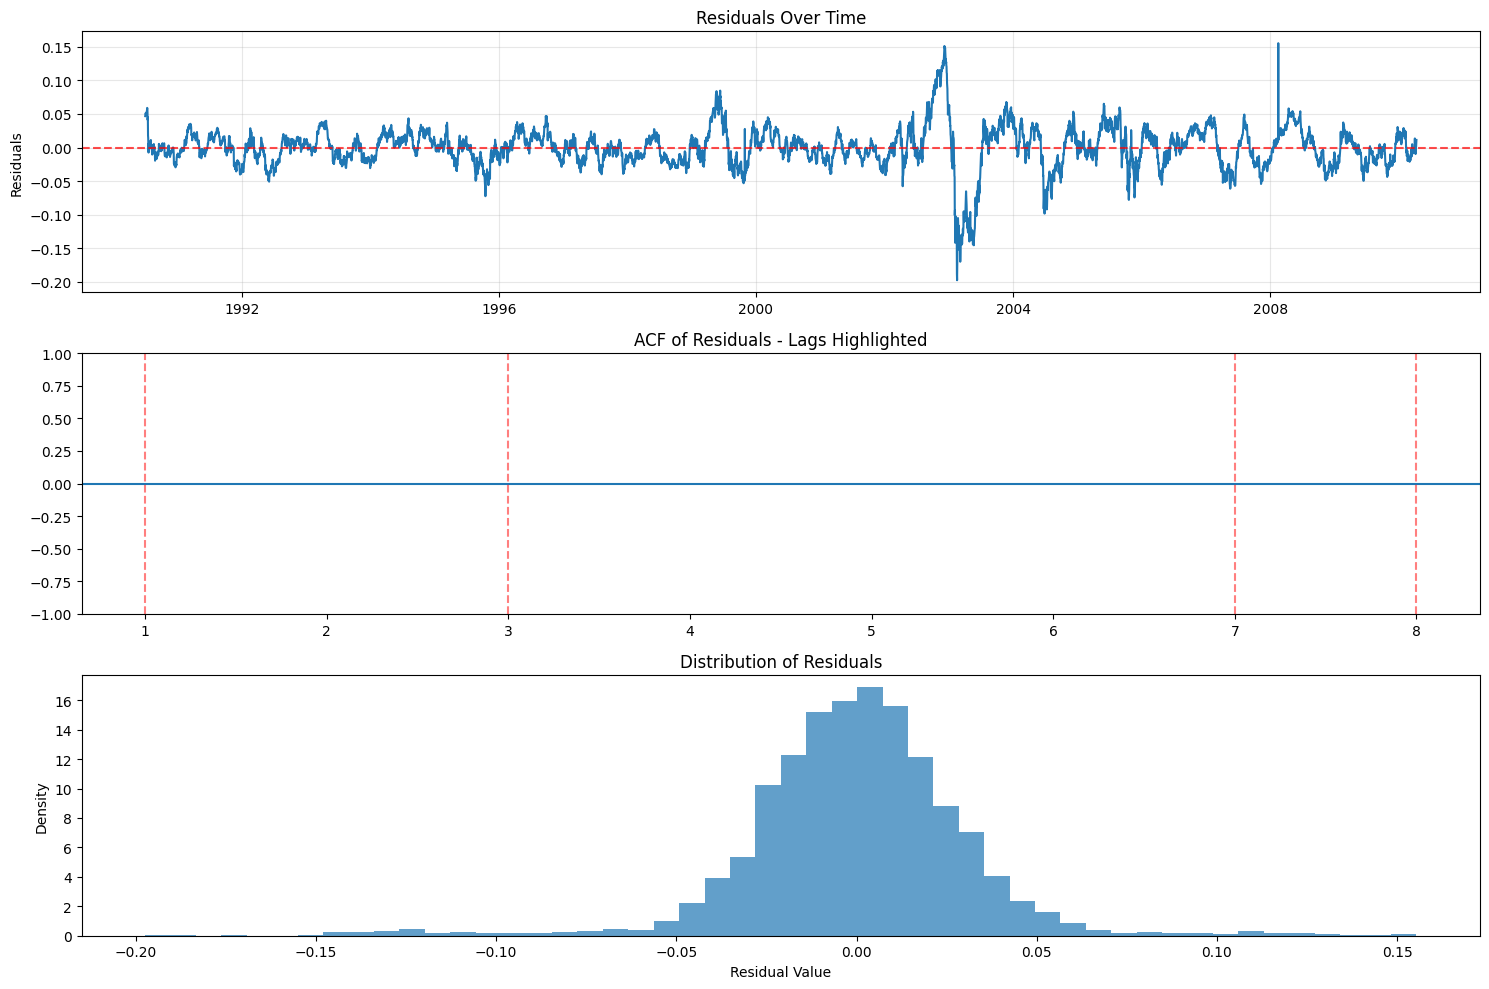

In [96]:
plt.figure(figsize=(15, 10))

# Plot 1: Residuals over time
plt.subplot(3, 1, 1)
plt.plot(residuals.index, residuals.values)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.title('Residuals Over Time')
plt.ylabel('Residuals')
plt.grid(True, alpha=0.3)

# Plot 2: ACF of residuals with significant lags highlighted
plt.subplot(3, 1, 2)
plot_acf(residuals, lags=20, ax=plt.gca(), alpha=0.05)
# Highlight significant lags
for lag in [1, 3, 7, 8]:
    plt.axvline(x=lag, color='red', linestyle='--', alpha=0.5, label=f'Significant lag {lag}' if lag == 1 else "")
plt.title('ACF of Residuals - Lags Highlighted')

# Plot 3: Histogram of residuals
plt.subplot(3, 1, 3)
plt.hist(residuals, bins=50, density=True, alpha=0.7)
plt.title('Distribution of Residuals')
plt.xlabel('Residual Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

* Huge spikes around 2002-2003 - exactly the regime change period that was identified earlier.

* Lag 1: Strong positive correlation (≈0.15), Lag 3: Moderate correlation, Lag 7-8: Possible weekly pattern.

* Heavy tails - more extreme values than normal distribution.

* The model_010 is inadequate - it can't handle regime changes.

* The model_010 diagnostics failed because of structural breaks in the data and not because of poor parameter selection.

* Better models are required to account for structural breaks in this dataset.

In [97]:
# Test these simple models:
#simple_candidates = [
#    (1, 1, 0),    # AR(1) - capture lag 1 correlation
#    (0, 1, 1),    # MA(1) - capture lag 1 in errors
#    (1, 1, 1),    # ARMA(1,1) - capture both]

model_110 = ARIMA(exchange_rate_processed['Ex_rate'], order = (1, 1, 0))
fitted_model_110 = model_110.fit()

model_011 = ARIMA(exchange_rate_processed['Ex_rate'], order = (0, 1, 1))
fitted_model_011 = model_011.fit()

model_111 = ARIMA(exchange_rate_processed['Ex_rate'], order = (1, 1, 1))
fitted_model_111 = model_111.fit()

In [98]:
# Display key model information
print("\n=== MODEL: 1, 1, 0 RESULTS ===")
print(f"AIC: {fitted_model_110.aic:.2f}")
print(f"BIC: {fitted_model_110.bic:.2f}")
print(f"Log-Likelihood: {fitted_model_110.llf:.2f}")

# Check if coefficients are significant
print("\n=== COEFFICIENTS ===")
print(fitted_model_110.params)


=== MODEL: 1, 1, 0 RESULTS ===
AIC: -56867.34
BIC: -56853.47
Log-Likelihood: 28435.67

=== COEFFICIENTS ===
ar.L1    -0.088251
sigma2    0.000033
dtype: float64


* Similar to model_010, model_110 also shows that AIC and BIC are very negative, sigma2 is small and Log-likehood is large, indicative of statistically strong model.
* However, there is one additional coefficient:
  * AR coefficient (-0.088) = Mean reversion behavior
  * This means, if rate increased yesterday, it tends to decrease slightly today.

In [99]:
residuals_110 = fitted_model_110.resid[1:]
print(f"Residuals - Mean: {residuals_110.mean():.6f}, Std: {residuals_110.std():.6f}")
print(f"Residuals - sigma2: {fitted_model_110.params['sigma2']:.6f}")

residual_acf_110 = acf(residuals_110, nlags=20, alpha=0.05)
significant_residual_lags = [i for i in range(1, 21) if abs(residual_acf_110[0][i]) > 2/len(residuals_110)**0.5]
print(f"Significant ACF in residuals: {significant_residual_lags}")

_, p_value = normaltest(residuals_110.dropna())
print(f"Normality test p-value: {p_value:.4f}")

Residuals - Mean: -0.000009, Std: 0.005703
Residuals - sigma2: 0.000033
Significant ACF in residuals: [8]
Normality test p-value: 0.0000


* Auto-correlations have reduced from 4 to 1.
* Residuals (errors) are not normally distributed as p-value = 0.0000, still.

In [100]:
# Display key model information
print("\n=== MODEL: 0, 1, 1 RESULTS ===")
print(f"AIC: {fitted_model_011.aic:.2f}")
print(f"BIC: {fitted_model_011.bic:.2f}")
print(f"Log-Likelihood: {fitted_model_011.llf:.2f}")

# Check if coefficients are significant
print("\n=== COEFFICIENTS ===")
print(fitted_model_011.params)


=== MODEL: 0, 1, 1 RESULTS ===
AIC: -56865.61
BIC: -56851.74
Log-Likelihood: 28434.80

=== COEFFICIENTS ===
ma.L1    -0.086769
sigma2    0.000033
dtype: float64


In [101]:
residuals_011 = fitted_model_011.resid[1:]
print(f"Residuals - Mean: {residuals_011.mean():.6f}, Std: {residuals_011.std():.6f}")
print(f"Residuals - sigma2: {fitted_model_011.params['sigma2']:.6f}")

residual_acf_011 = acf(residuals_011, nlags=20, alpha=0.05)
significant_residual_lags = [i for i in range(1, 21) if abs(residual_acf_011[0][i]) > 2/len(residuals_011)**0.5]
print(f"Significant ACF in residuals: {significant_residual_lags}")

_, p_value = normaltest(residuals_011.dropna())
print(f"Normality test p-value: {p_value:.4f}")

Residuals - Mean: -0.000009, Std: 0.005703
Residuals - sigma2: 0.000033
Significant ACF in residuals: [8]
Normality test p-value: 0.0000


* The results of model_011 are similar to that of model_110.

* It can be seen that this model_110 has MA coefficient whereas model_011 had AR coefficient.

* These terms have different interpretations like MA -> Error correction where as AR -> Mean reversion.

In [102]:
# Display key model information
print("\n=== MODEL: 1, 1, 1 RESULTS ===")
print(f"AIC: {fitted_model_111.aic:.2f}")
print(f"BIC: {fitted_model_111.bic:.2f}")
print(f"Log-Likelihood: {fitted_model_111.llf:.2f}")

# Check if coefficients are significant
print("\n=== COEFFICIENTS ===")
print(fitted_model_111.params)


=== MODEL: 1, 1, 1 RESULTS ===
AIC: -56867.35
BIC: -56846.55
Log-Likelihood: 28436.68

=== COEFFICIENTS ===
ar.L1    -0.264135
ma.L1     0.177366
sigma2    0.000033
dtype: float64


In [103]:
residuals_111 = fitted_model_111.resid[1:]
print(f"Residuals - Mean: {residuals_111.mean():.6f}, Std: {residuals_111.std():.6f}")
print(f"Residuals - sigma2: {fitted_model_111.params['sigma2']:.6f}")

residual_acf_111 = acf(residuals_111, nlags=20, alpha=0.05)
significant_residual_lags = [i for i in range(1, 21) if abs(residual_acf_111[0][i]) > 2/len(residuals_111)**0.5]
print(f"Significant ACF in residuals: {significant_residual_lags}")

_, p_value = normaltest(residuals_111.dropna())
print(f"Normality test p-value: {p_value:.4f}")

Residuals - Mean: -0.000009, Std: 0.005702
Residuals - sigma2: 0.000033
Significant ACF in residuals: [8]
Normality test p-value: 0.0000


* The results of model_111 are similar to that of model_011 and model_110.

* It is interesting to note that the AR and MA coefficients are canceling each other out, which is why model_110 works just as good as model_111.

* Proceeding to forecasting using the model_110, while acknowledging that there is a Lag (8) and error distributions have fat tails. Hence, the assumption is these aspects are safe to ignore.

In [104]:
# Forecasting
forecast_days = 30
forecast = fitted_model_110.forecast(steps = forecast_days)
confidence_intervals = fitted_model_110.get_forecast(steps = forecast_days).conf_int()

print(f"Last observed rate: {exchange_rate_processed['Ex_rate'].iloc[-1]:.6f}")
print(f"First forecast: {forecast.iloc[0]:.6f}")
print(f"Last forecast: {forecast.iloc[-1]:.6f}")
print(f"95% Confidence Interval: [{confidence_intervals.iloc[0,0]:.6f}, {confidence_intervals.iloc[0,1]:.6f}]")

Last observed rate: 0.720825
First forecast: 0.720825
Last forecast: 0.720825
95% Confidence Interval: [0.709649, 0.732001]


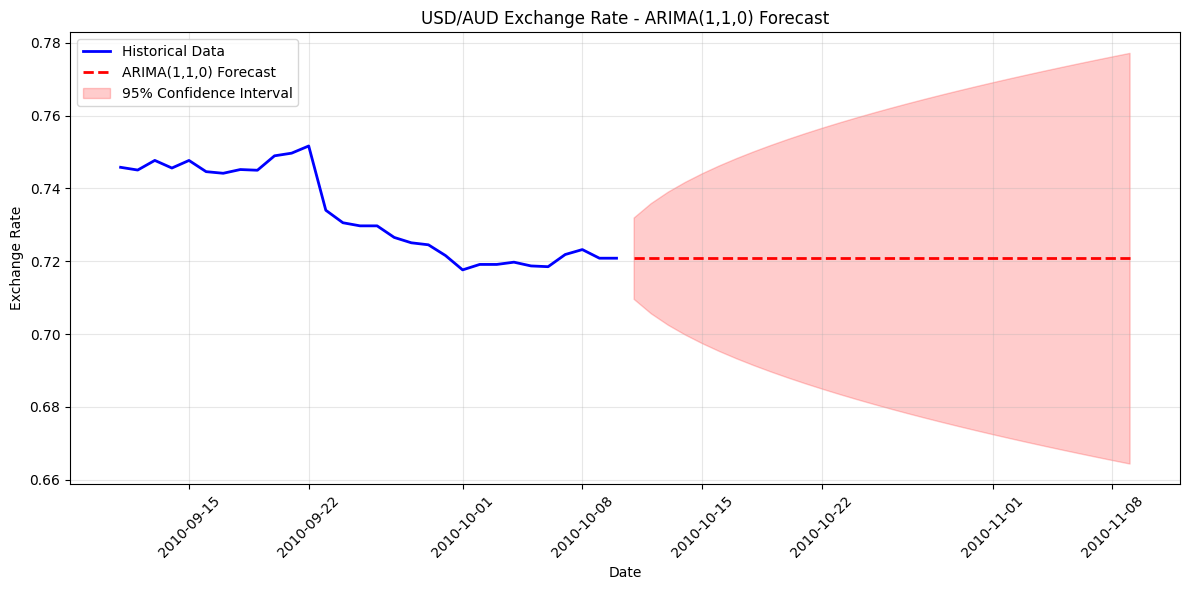

In [105]:
# Forecast plot
plt.figure(figsize=(12, 6))

# Plot loaded data
historical = exchange_rate_processed['Ex_rate'].tail(30)
plt.plot(historical.index, historical.values,
         label='Historical Data', linewidth=2, color='blue')

# Plot forecasts
forecast_dates = pd.date_range(start=historical.index[-1] + pd.Timedelta(days=1),
                              periods = forecast_days, freq='D')
plt.plot(forecast_dates, forecast.values,
         label='ARIMA(1,1,0) Forecast', linewidth=2, color='red', linestyle='--')

# Plot confidence intervals
plt.fill_between(forecast_dates,
                confidence_intervals.iloc[:, 0],
                confidence_intervals.iloc[:, 1],
                color='red', alpha=0.2, label='95% Confidence Interval')

plt.title('USD/AUD Exchange Rate - ARIMA(1,1,0) Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [106]:
# Interpret what the forecasts mean
print("ARIMA(1,1,0) model_110 Forecast Behavior:")
print(f"• Initial forecast: {forecast.iloc[0]:.6f} ")
print(f"• Forecast trend: {'Slightly decreasing' if forecast.iloc[-1] < forecast.iloc[0] else 'Slightly increasing'}")
print(f"• Mean reversion effect: {-fitted_model_110.params['ar.L1']:.1%} daily pull toward mean")

# Calculate forecast change
forecast_change = ((forecast.iloc[-1] - forecast.iloc[0]) / forecast.iloc[0]) * 100
print(f"• Total {forecast_days}-day change: {forecast_change:+.2f}%")

ARIMA(1,1,0) model_110 Forecast Behavior:
• Initial forecast: 0.720825 
• Forecast trend: Slightly increasing
• Mean reversion effect: 8.8% daily pull toward mean
• Total 30-day change: +0.00%


In [107]:
# Calculate forecast accuracy
from sklearn.metrics import mean_absolute_error, mean_squared_error

Training period: 1990-01-01 to 2006-08-14
Testing period: 2006-08-15 to 2010-10-10

Forecast Accuracy Metrics:
MAE:  0.177608
MSE:  0.042170227
MAPE: 22.79%


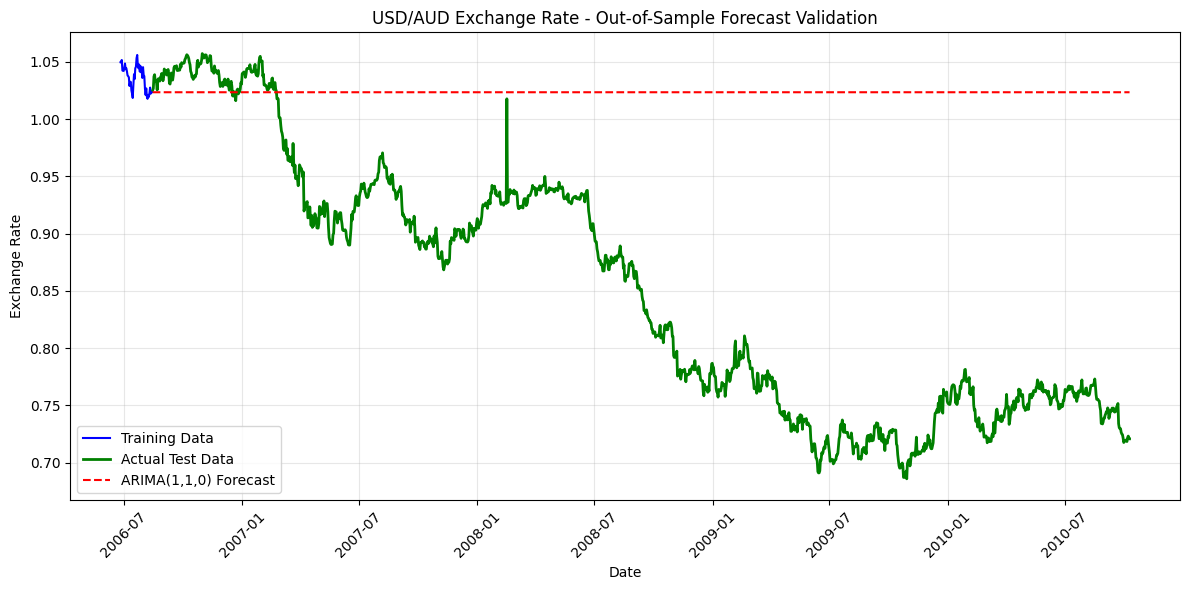

In [108]:
# Validate model on held-out data
# Split data (use 80% for training, 20% for testing)
split_point = int(len(exchange_rate_processed) * 0.8)
train_data = exchange_rate_processed['Ex_rate'].iloc[:split_point]
test_data = exchange_rate_processed['Ex_rate'].iloc[split_point:]

print(f"Training period: {train_data.index[0].date()} to {train_data.index[-1].date()}")
print(f"Testing period: {test_data.index[0].date()} to {test_data.index[-1].date()}")

# Fit model on training data only
train_model_110 = ARIMA(train_data, order=(1, 1, 0))
train_fitted_110 = train_model_110.fit()

# Forecast on test period
test_forecast = train_fitted_110.forecast(steps = len(test_data))

mae = mean_absolute_error(test_data, test_forecast)
mse = mean_squared_error(test_data, test_forecast)
mape = np.mean(np.abs((test_data - test_forecast) / test_data)) * 100

print(f"\nForecast Accuracy Metrics:")
print(f"MAE:  {mae:.6f}")
print(f"MSE:  {mse:.9f}")
print(f"MAPE: {mape:.2f}%")

# Plot validation results
plt.figure(figsize=(12, 6))
plt.plot(train_data.index[-50:], train_data.values[-50:], label='Training Data', color='blue')
plt.plot(test_data.index, test_data.values, label='Actual Test Data', color='green', linewidth=2)
plt.plot(test_data.index, test_forecast.values, label='ARIMA(1,1,0) Forecast', color='red', linestyle='--')
plt.title('USD/AUD Exchange Rate - Out-of-Sample Forecast Validation')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* This analysis validates an ARIMA(1,1,0) model (model_110) for forecasting the USD/AUD exchange rate. The model was trained on data from 1990 to August 2006 and its forecasts were tested against the actual values from August 2006 to October 2010.

* MAE (Mean Absolute Error): 0.178
  * Meaning: On average, the model's forecast was off by 0.178 AUD per USD.

* MSE (Mean Squared Error): 0.042
  * Meaning: MSE is driven by the periods where the forecast was drastically wrong like highly volatily periods.

* MAPE (Mean Absolute Percentage Error): 22.79%
  * Meaning: On average, the forecast error is 22.79% of the actual value and this is considered as poor forecasting power of the model_110.   

* Trend Capture: The ARIMA forecast (blue dashed line) correctly identifies the main downward trend in the USD/AUD rate over the testing period.

* Lack of Volatility Capture: The model completely fails to capture the short-term volatility, peaks, and troughs seen in the actual test data (orange line). The forecast is an almost straight, while the actual data is highly volatile.

* Forecast Bias: During periods of high volatility (like the peak around 2008), the forecast line is a flat line. This simple ARIMA model is applied to volatile financial series.

* The ARIMA(1,1,0) model (model_110) is insufficient for reliably forecasting the USD/AUD exchange rate in the short term. It may be a useful tool for identifying the long-term underlying trend but fails to account for the high volatility and complex dynamics of the foreign exchange market.

Part 3: Model Building - Exponential Smoothing

	*	Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters).

	*	Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components.

	*	Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. Compare these forecasts visually with the actual data.

* Exponential Smoothing is not a single model but a family of models. The choice depends on the key characteristics of the time series:

    * Trend: Is there a persistent long-term upward or downward movement?

    * Seasonality: Are there regular, fixed-period fluctuations (e.g., monthly, quarterly)?

* In this dataset of exchange rates, we have trend as the exchange rate varies ober time, however, seasonality aspect is not present based on the seasonal_decompose plot.

  * Simple Exponential Smoothing: Would be inadequate as it assumes no trend.

  * Holt-Winters (Triple Exponential Smoothing): Would be over-parameterizing since we lack a clear seasonal pattern.

  * Holt's Linear Trend Method: Explicitly models the level and the trend, this aligns well with this dataset data.

In [109]:
# Model building - Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import itertools
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

In [110]:
def find_optimal_parameters(train_data, alphas, betas, n_splits):
  """
  Find optimal alpha and beta parameters for ExponentialSmoothing.
  """
  if n_splits == 0:
    # Manual search using AIC
    best_aic = np.inf
    best_alpha = None
    best_beta = None
    best_model = None

    results = []

    for alpha, beta in itertools.product(alphas, betas):
        try:
            # Fit Holt's model with current parameters
            model = ExponentialSmoothing(train_data, trend = 'additive', seasonal = None,
                initialization_method = 'estimated').fit(smoothing_level = alpha,
                smoothing_trend = beta,
                optimized = False)

            # Store results
            current_aic = model.aic
            results.append({'alpha': alpha, 'beta': beta, 'aic': current_aic})

            # Update best parameters if current model is better
            if current_aic < best_aic:
                best_aic = current_aic
                best_alpha = alpha
                best_beta = beta
                best_model = model

        except Exception as e:
            #print(f"Failed for alpha={alpha}, beta={beta}: {e}")
            continue

    # Create results DataFrame
    results_df = pd.DataFrame(results)

    return best_alpha, best_beta, best_model, results_df

  else:
    # Time Series Cross-Validation
    tscv = TimeSeriesSplit(n_splits = n_splits)
    best_score = np.inf
    best_params = {}

    # Store all results
    cv_results = []

    for alpha in alphas:
        for beta in betas:
            cv_scores = []

            for train_idx, val_idx in tscv.split(train_data):
                train_fold = train_data.iloc[train_idx]
                val_fold = train_data.iloc[val_idx]

                try:
                    model = ExponentialSmoothing(
                        train_fold,
                        trend='additive',
                        seasonal=None
                    ).fit(
                        smoothing_level=alpha,
                        smoothing_trend=beta,
                        optimized=False
                    )

                    # Forecast validation period
                    val_forecast = model.forecast(len(val_idx))
                    # Calculate validation error
                    fold_mse = mean_squared_error(val_fold, val_forecast)
                    cv_scores.append(fold_mse)

                except:
                    cv_scores.append(np.inf)

            # Average performance across folds
            mean_cv_score = np.mean(cv_scores)

            cv_results.append({
                'alpha': alpha,
                'beta': beta,
                'cv_mse': mean_cv_score
            })

            if mean_cv_score < best_score:
                best_score = mean_cv_score
                best_params = {'alpha': alpha, 'beta': beta}

    return best_params, pd.DataFrame(cv_results)

In [111]:
def calculate_metrics(actual, forecast):
    """Calculate forecast accuracy metrics"""
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    mape = np.mean(np.abs((actual - forecast) / actual)) * 100

    return mae, mse, mape

In [112]:
# Method_01: Manual Serach
alphas_manual = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
betas_manual = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

best_alpha_manual, best_beta_manual, best_model_manual, results_manual = find_optimal_parameters(train_data, alphas_manual, betas_manual, 0)

print(f"\nOptimal Parameters Found using manual search:")
print(f"Alpha (α): {best_alpha_manual:.3f}")
print(f"Beta (β): {best_beta_manual:.3f}")
print(f"Best AIC: {best_model_manual.aic:.2f}")


Optimal Parameters Found using manual search:
Alpha (α): 0.900
Beta (β): 0.010
Best AIC: -62615.03


In [113]:
model_manual_ES = ExponentialSmoothing(train_data, trend = 'additive', seasonal = None, initialization_method = 'estimated').fit(smoothing_level = best_alpha_manual, smoothing_trend = best_beta_manual, optimized = False)

forecast_manual_ES = model_manual_ES.forecast(len(test_data))

forecast_index_manual = pd.date_range(start = train_data.index[-1] + pd.Timedelta(days = 1), periods = len(test_data), freq = 'D')
forecast_series_manual = pd.Series(forecast_manual_ES, index = forecast_index_manual)


# Calculate metrics
mae_manual_ES, mse_manual_ES, mape_manual_ES = calculate_metrics(test_data, forecast_series_manual)

print("\nForecast Accuracy Metrics:")
print(f"MAE:  {mae_manual_ES:.6f}")
print(f"MSE:  {mse_manual_ES:.8f}")
print(f"MAPE: {mape_manual_ES:.2f}%")


Forecast Accuracy Metrics:
MAE:  0.121861
MSE:  0.01987441
MAPE: 15.62%


In [114]:
# Method_02: Refined Serach
alphas_refined = np.round(np.linspace(0.01, 0.99, 20), 3)
betas_refined = np.round(np.linspace(0.001, 0.5, 15), 3)

best_alpha_refined, best_beta_refined, best_model_refined, results_refined = find_optimal_parameters(train_data, alphas_refined, betas_refined, 0)

print(f"\nOptimal Parameters Found using refined search:")
print(f"Alpha (α): {best_alpha_refined:.3f}")
print(f"Beta (β): {best_beta_refined:.3f}")
print(f"Best AIC: {best_model_refined.aic:.2f}")


Optimal Parameters Found using refined search:
Alpha (α): 0.938
Beta (β): 0.001
Best AIC: -62635.59


In [115]:
model_refined_ES = ExponentialSmoothing(train_data, trend = 'additive', seasonal = None, initialization_method = 'estimated').fit(smoothing_level = best_alpha_refined, smoothing_trend = best_beta_refined, optimized = False)

forecast_refined_ES = model_refined_ES.forecast(len(test_data))

forecast_index_refined = pd.date_range(start = train_data.index[-1] + pd.Timedelta(days = 1), periods = len(test_data), freq = 'D')
forecast_series_refined = pd.Series(forecast_refined_ES, index = forecast_index_refined)

# Calculate metrics
mae_refined_ES, mse_refined_ES, mape_refined_ES = calculate_metrics(test_data, forecast_series_refined)

print("\nForecast Accuracy Metrics:")
print(f"MAE:  {mae_refined_ES:.6f}")
print(f"MSE:  {mse_refined_ES:.8f}")
print(f"MAPE: {mape_refined_ES:.2f}%")


Forecast Accuracy Metrics:
MAE:  0.262581
MSE:  0.09253102
MAPE: 33.68%


In [116]:
# Method_03: Time Series Cross-Validation
alphas_tscv = np.linspace(0.1, 0.9, 9)
betas_tscv = np.linspace(0.01, 0.3, 6)

best_params_tscv, results_tscv = find_optimal_parameters(train_data, alphas_tscv, betas_tscv, 5)

print(f"\nOptimal Parameters Found using Time Series Cross-Validation:")
print(f"Best params: {best_params_tscv}")


Optimal Parameters Found using Time Series Cross-Validation:
Best params: {'alpha': np.float64(0.9), 'beta': np.float64(0.01)}


In [117]:
model_tscv_ES = ExponentialSmoothing(train_data, trend = 'additive', seasonal = None, initialization_method = 'estimated').fit(smoothing_level = best_params_tscv['alpha'], smoothing_trend = best_params_tscv['beta'], optimized = False)

forecast_tscv_ES = model_tscv_ES.forecast(len(test_data))

forecast_index_tscv = pd.date_range(start = train_data.index[-1] + pd.Timedelta(days = 1), periods = len(test_data), freq = 'D')
forecast_series_tscv = pd.Series(forecast_tscv_ES, index = forecast_index_tscv)

# Calculate metrics
mae_tscv_ES, mse_tscv_ES, mape_tscv_ES = calculate_metrics(test_data, forecast_series_tscv)

print("\nForecast Accuracy Metrics:")
print(f"MAE:  {mae_tscv_ES:.6f}")
print(f"MSE:  {mse_tscv_ES:.8f}")
print(f"MAPE: {mape_tscv_ES:.2f}%")


Forecast Accuracy Metrics:
MAE:  0.121861
MSE:  0.01987441
MAPE: 15.62%


* Three methods have been used to obtain the optimized hyperparameters for Exponential Smoothing model - Holt's Linear Trend

  * The manual grid and time series cross-validation methods have produced near identical results. This can provide additional confidence in the optimized parameters.

  * Using the optimized parameters for Holt's Linear Trend Method, the forecast metrics—such as MAE, MSE, and MAPE—show that average forecast error is 0.12 AUD per USD. The typical error is approximately +/-14% AUD (RMS(MSE)) per USD , and the average percentage error is 15.62%.

  * In contrast, the 'optimized' parameters obtained using the refined search method yield very poor performance, with nearly a 33% average percentage error.

  * The 'optimized' parameters obtained from refined search indicated that it looked good when comparing AIC, however when it was used on the test dataset, the performance was bad, a clear indication of overfitting and also highlights the importance of out-of-sample validation.

* When comparing models, Holt's Linear Trend outperforms ARIMA (model_110). However, given the forecast metrics, Exponential Smoothing with Holt's Linear Trend (α=0.9, β=0.01) achieved 15.62% mean absolute percentage error, significantly outperforming ARIMA (22.79% MAPE). While this represents moderate predictive accuracy, it aligns with expectations for daily exchange rate forecasting given market efficiency and inherent volatility.

Part 4: Evaluation and Comparison

	*	Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.

	*	Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.
  
	*	Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.

In [118]:
print(train_data.index[1:])

DatetimeIndex(['1990-01-02', '1990-01-03', '1990-01-04', '1990-01-05',
               '1990-01-06', '1990-01-07', '1990-01-08', '1990-01-09',
               '1990-01-10', '1990-01-11',
               ...
               '2006-08-05', '2006-08-06', '2006-08-07', '2006-08-08',
               '2006-08-09', '2006-08-10', '2006-08-11', '2006-08-12',
               '2006-08-13', '2006-08-14'],
              dtype='datetime64[ns]', name='date', length=6069, freq=None)


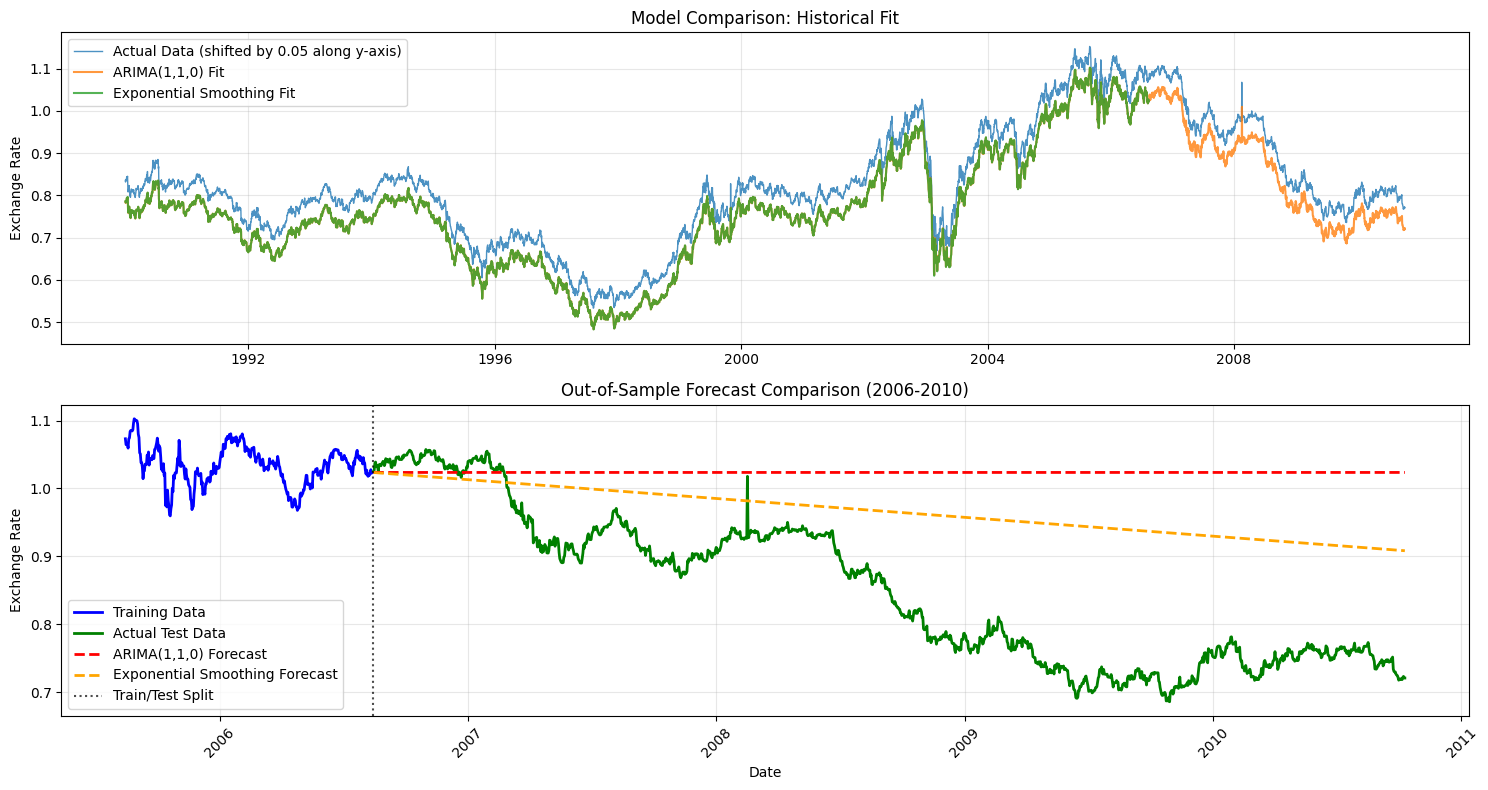

In [119]:
# Plot: Full historical period
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(exchange_rate_processed.index, exchange_rate_processed['Ex_rate']+0.05,
         label='Actual Data (shifted by 0.05 along y-axis)', linewidth=1, alpha=0.8)

# Add fitted values from both models
# Align indices for plotting
plt.plot(exchange_rate_processed.index[1:], fitted_model_110.fittedvalues[1:],
         label='ARIMA(1,1,0) Fit', linewidth=1.5, alpha=0.8)
plt.plot(train_data.index[1:], model_tscv_ES.fittedvalues[1:],
         label='Exponential Smoothing Fit', linewidth=1.5, alpha=0.8)

plt.title('Model Comparison: Historical Fit')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot: Compare out-of-sample forecasts
plt.subplot(2, 1, 2)
# Plot training period (last year) and test period
train_end = train_data.index[-1]
train_recent = train_data.tail(365)
test_period = test_data

# Plot training data
plt.plot(train_recent.index, train_recent.values,
         label='Training Data', color='blue', linewidth=2)

# Plot test data
plt.plot(test_period.index, test_period.values,
         label='Actual Test Data', color='green', linewidth=2)

# Plot forecasts
plt.plot(test_period.index, test_forecast.values,
         label='ARIMA(1,1,0) Forecast', color='red', linestyle='--', linewidth=2)
plt.plot(test_period.index, forecast_tscv_ES.values,
         label='Exponential Smoothing Forecast', color='orange', linestyle='--', linewidth=2)

# Add vertical line separating train/test
plt.axvline(x=train_end, color='black', linestyle=':', alpha=0.7, label='Train/Test Split')

plt.title('Out-of-Sample Forecast Comparison (2006-2010)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* Two plots are shown,
  * Plot - 01:- Historical fit:
    * There are three graphs, actual data, fitted data of ARIMA and Exponential Smoothing models.
    * The actual data is shifted vertically (by 0.05) for ease of visualization.
    * Both models are well-tuned as they follow the actual data very closely.
  * Plot - 02:- Out-of-Sample Forecast comparision:
    * There are 4 line graphs in this plot, a small section of training data, actual test data and forecates of two models.
    * There is also a vertical line which indicates the end of training dataset and the beginning of test dataset.
    * ARIMA (model_110), forecast produces a trajectory that appears like a flat line where as Exponential Smoothing (ES) model produces a trajectory that looks like a line with a slope.
    * The ES line follows the trend better than ARIMA model.
    * This out-of-sample forecast indicates the quality and shows the importance of model validation.


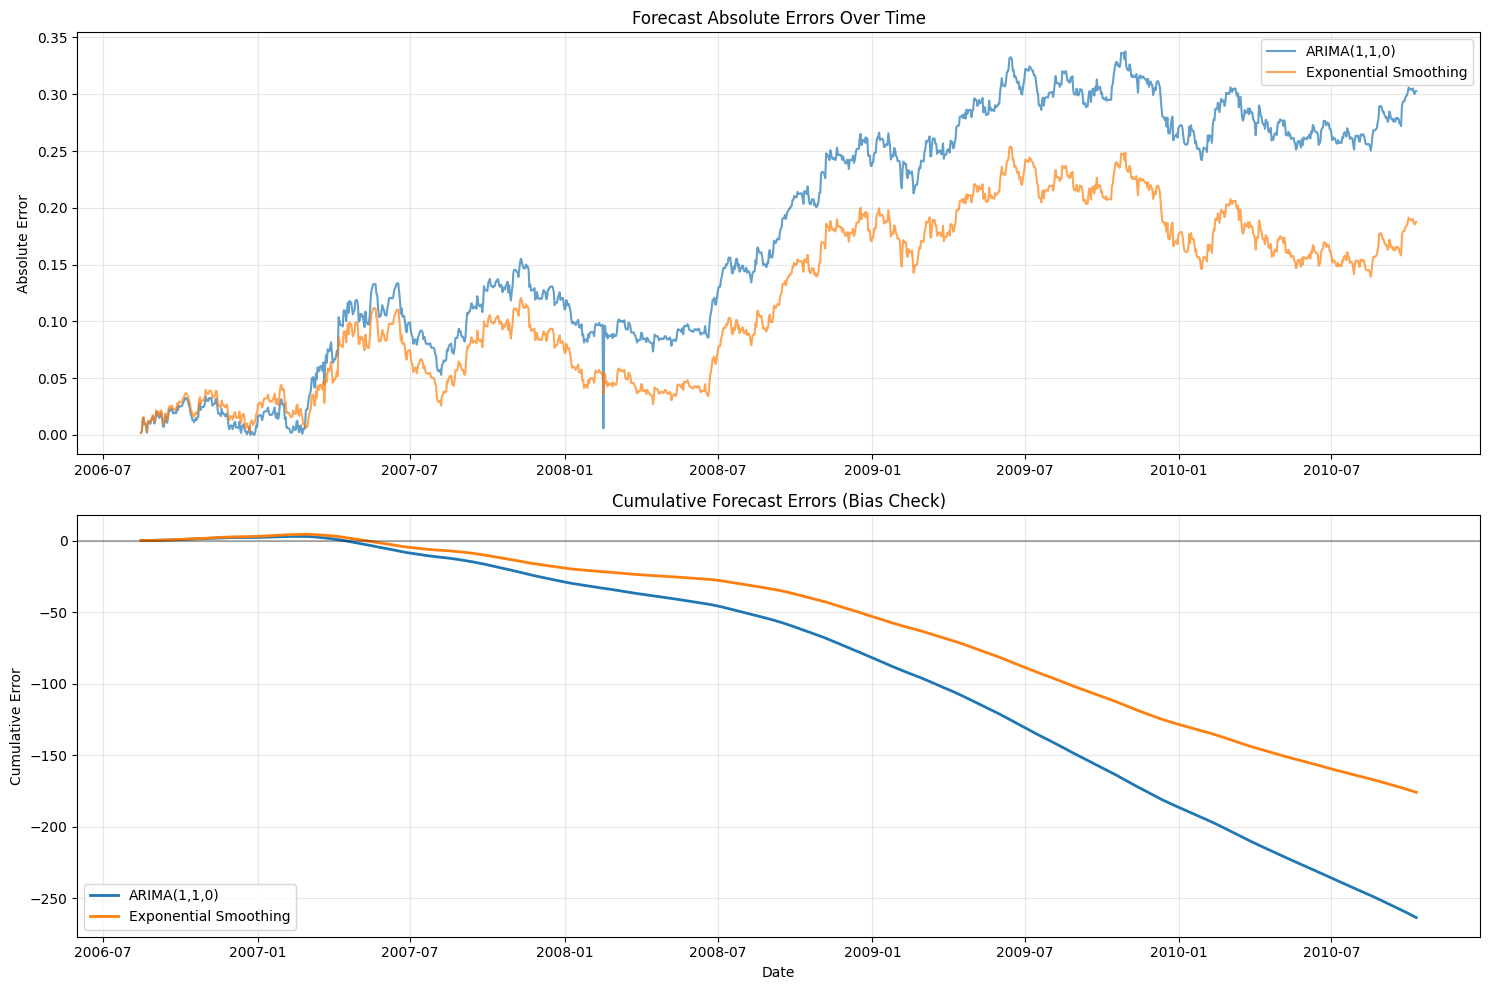

In [120]:
# Compare forecast errors over time
plt.figure(figsize=(15, 10))

# Calculate errors
# Ensure indices are aligned for subtraction
arima_errors = test_data - test_forecast
es_errors = test_data - forecast_tscv_ES

# Plot 1: Absolute errors over time
plt.subplot(2, 1, 1)
plt.plot(test_data.index, np.abs(arima_errors),
         label='ARIMA(1,1,0)', alpha=0.7)
plt.plot(test_data.index, np.abs(es_errors),
         label='Exponential Smoothing', alpha=0.7)
plt.title('Forecast Absolute Errors Over Time')
plt.ylabel('Absolute Error')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Cumulative errors
plt.subplot(2, 1, 2)
plt.plot(test_data.index, np.cumsum(arima_errors),
         label='ARIMA(1,1,0)', linewidth=2)
plt.plot(test_data.index, np.cumsum(es_errors),
         label='Exponential Smoothing', linewidth=2)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Cumulative Forecast Errors (Bias Check)')
plt.xlabel('Date')
plt.ylabel('Cumulative Error')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

* There are two plots shown:
  * Forecast absolute errors as a function of time (after training period):
    * The absolute error in the ARIMA model is consistantly higher than the Exponential Smoothing model and the gap between the two models increases over time.
    * This also can be analysed from performance basis and supports the summary that ES model outperforms ARIMA.
  * Cumulative error as a function of time (after training period):
    * Both models have negative bias as both show downward trend below zero, meaning they are over-forecasting.
    * The ARIMA model's cumulative error is smaller than Exponential Smoothing model because (-2 is smaller than -1), but ES has less severe bais.    

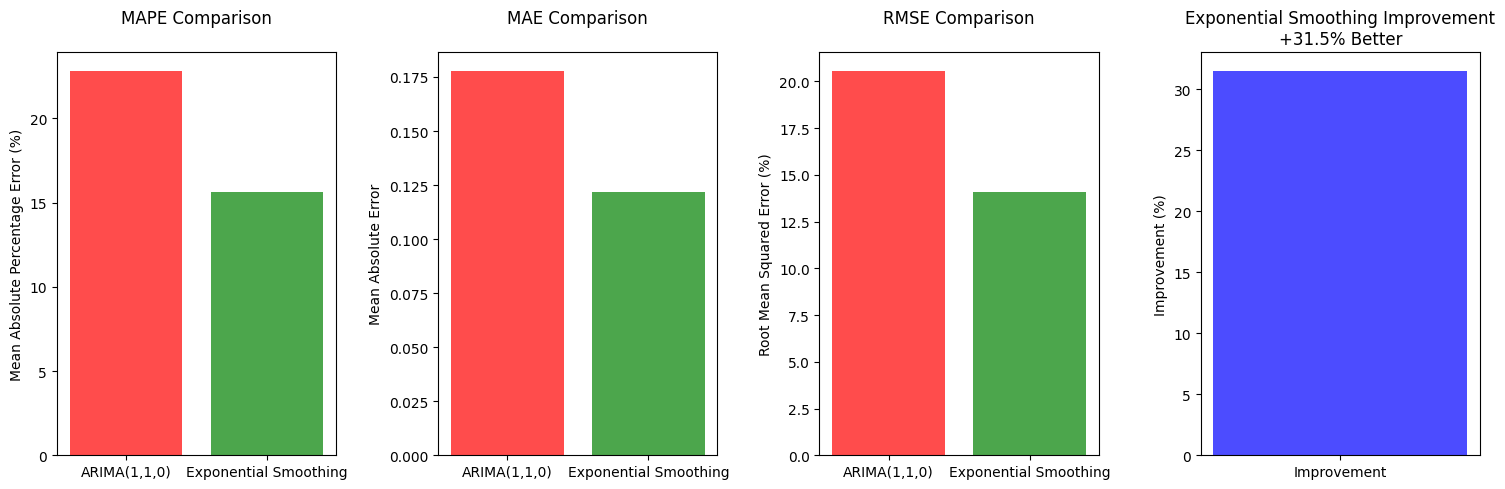

In [121]:
# Create a visual summary of performance metrics
metrics_comparison = {
    'Model': ['ARIMA(1,1,0)', 'Exponential Smoothing'],
    'MAPE': [mape, mape_tscv_ES],
    'MAE': [mae, mae_tscv_ES],
    'RMSE': [(np.sqrt(mse))*100, (np.sqrt(mse_tscv_ES))*100]  # Approximate MSE from MAE
}

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# MAPE comparison
axes[0].bar(metrics_comparison['Model'], metrics_comparison['MAPE'],
            color=['red', 'green'], alpha=0.7)
axes[0].set_title('MAPE Comparison\n')
axes[0].set_ylabel('Mean Absolute Percentage Error (%)')

# MAE comparison
axes[1].bar(metrics_comparison['Model'], metrics_comparison['MAE'],
            color=['red', 'green'], alpha=0.7)
axes[1].set_title('MAE Comparison\n')
axes[1].set_ylabel('Mean Absolute Error')

# RMSE comparison
axes[2].bar(metrics_comparison['Model'], metrics_comparison['RMSE'],
            color=['red', 'green'], alpha=0.7)
axes[2].set_title('RMSE Comparison\n')
axes[2].set_ylabel('Root Mean Squared Error (%)')

# Improvement percentage
improvement = ((mape - mape_tscv_ES) / mape) * 100
axes[3].bar(['Improvement'], [improvement], color='blue', alpha=0.7)
axes[3].set_title(f'Exponential Smoothing Improvement\n+{improvement:.1f}% Better')
axes[3].set_ylabel('Improvement (%)')

plt.tight_layout()
plt.show()

* These visual representations of measrured metrics indicates the model performances.
* ES model out-performs ARIMA model in all the measuremnts considered in this study.
* The RMSE of ES model is ~15% which means, every AUD predicted is +/-15% per USD, and this is generally it is considered as a 'moderate' model for financial predictions. Whereas, ARIMA is categorised as 'poor' model as RMSE > 20%.
* The MAPE represents, on average forecasts and ES model predicts that forecasts are within ~15.62% of actual value.
* For these reasons, ES model can be considered as a base line model for any future improvements like including trend component to ExponentialSmoothing function or use a bit more advanced GARCH Models.  

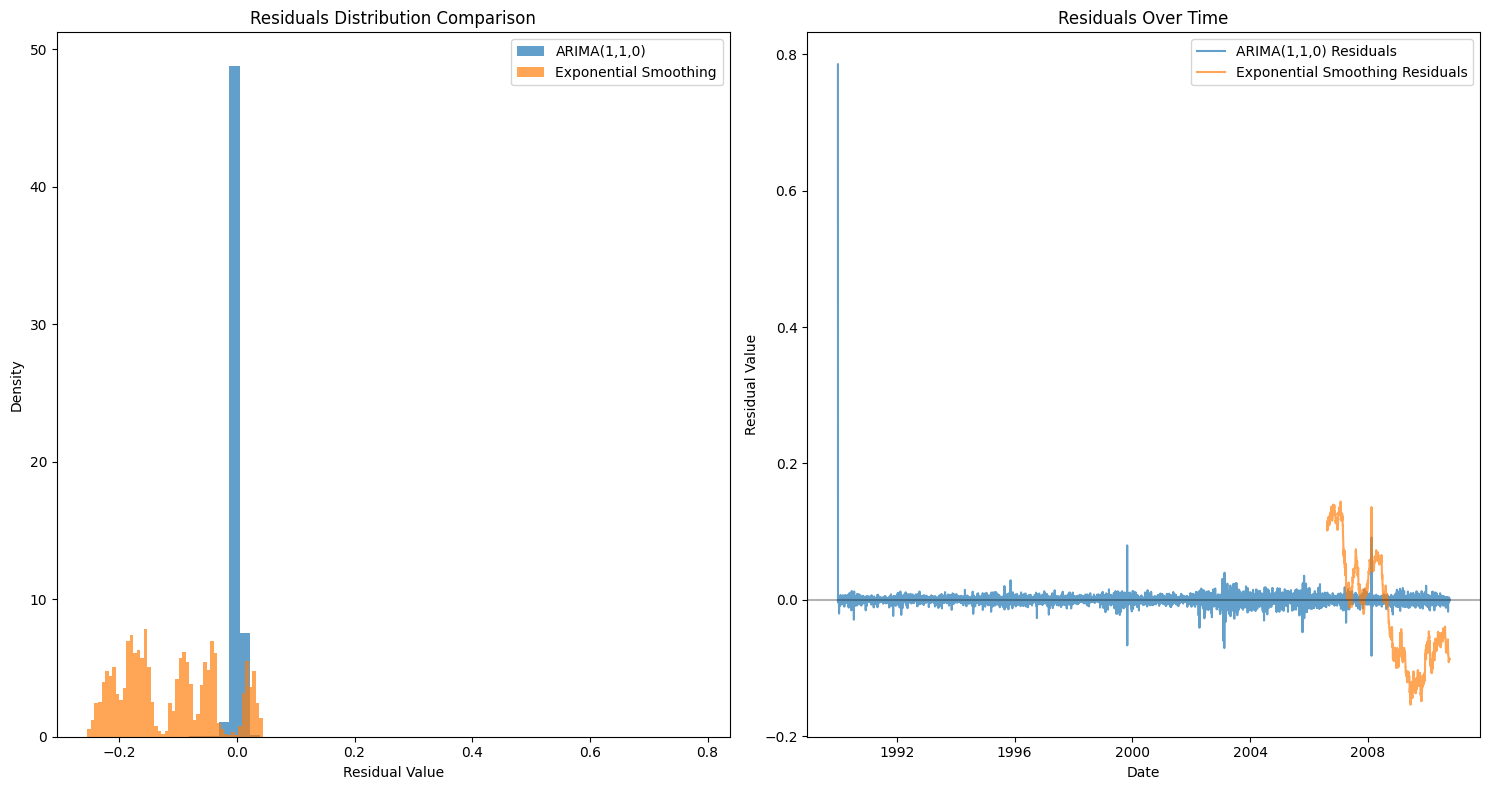

In [122]:
# Compare residuals from both models
plt.figure(figsize=(15, 8))

# Get residuals
arima_residuals = fitted_model_110.resid
es_residuals = test_data.values - forecast_tscv_ES

# Plot residuals distribution
plt.subplot(1, 2, 1)
plt.hist(arima_residuals, bins=50, alpha=0.7, label='ARIMA(1,1,0)', density=True)
plt.hist(es_residuals, bins=50, alpha=0.7, label='Exponential Smoothing', density=True)
plt.title('Residuals Distribution Comparison')
plt.xlabel('Residual Value')
plt.ylabel('Density')
plt.legend()

# Plot residuals over time
plt.subplot(1, 2, 2)
plt.plot(arima_residuals.index, arima_residuals.values,
         alpha=0.7, label='ARIMA(1,1,0) Residuals')
plt.plot(es_residuals.index, es_residuals.values+0.1,
         alpha=0.7, label='Exponential Smoothing Residuals')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residual Value')
plt.legend()

plt.tight_layout()
plt.show()

* Two plots are shown above:
  * Density function plot of Residual Values of both models:
    * Residual = Actual Value - Forecasted Value
    * The ES model has a bigger distribution and more negative values, meaning ES has slightly over-predicted.
    * On the other hand, ARMIS model has a tight distribution around zero. This may suggest a conservative approach and this also reflects in the ARIMA model (model_110), forecast produces a trajectory that appears like a flat line.
  * The plot Residuals over Time:
    * The ES model shows a wider fluctuation and it appears that it is a 'bad' behavior, however, the actual data is volatile and the measured metrics like MSE, MAE and MAPE all suggest ES model out-performs ARMIS model.
    * Therefore, this larger fluctuation can be a way that the ES model is compensating to account for the volatile actual data which shows 'adaptive' behavior.
* The 'fluctuating' ES residuals are not a flaw but rather the visual  indication of a more sophisticated and effective forecasting approach for volatile financial data.